$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Big Data Research

*Jason Stock*

In [1]:
import pandas as pd
import numpy as np 
import random
import time
from pprint import pprint
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import neuralnetworks as nn
import mlutils as ml
import warnings

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
mpl.style.use('default')

### Functions
Same `trainNNs, summarize, bestNetwork, printBest` from PA5.

In [2]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures,
             numberRepetitions, numberIterations, classify = False):
    train_p, test_p, timing = [], [], []
    for network in hiddenLayerStructures:
        l_train_p, l_test_p = [], []
        sT = time.time()
        for rep in range(0, numberRepetitions):
            Xtrain, Ttrain, Xtest, Ttest = ml.partition(X, T,
                                                        (trainFraction, 1 - trainFraction),
                                                        classification = classify)
            if classify:
                nnet = nn.NeuralNetworkClassifier(Xtrain.shape[1],
                                                  network,
                                                  np.unique(T).shape[0])
                nnet.train(Xtrain, Ttrain, numberIterations)
                
                Ytrain = nnet.use(Xtrain)
                Ytest  = nnet.use(Xtest)
                
                l_train_p.append( np.sum(Ytrain!=Ttrain)/len(Ttrain) )
                l_test_p.append( np.sum(Ytest!=Ttest)/len(Ttest) )
            else:
                nnet = nn.NeuralNetwork(Xtrain.shape[1],
                                        network,
                                        Ttrain.shape[1])
                nnet.train(Xtrain, Ttrain, numberIterations)
    
                Ytrain = nnet.use(Xtrain)
                Ytest  = nnet.use(Xtest)
            
                l_train_p.append( np.sqrt(np.mean( (Ytrain - Ttrain)**2)) )
                l_test_p.append( np.sqrt(np.mean( (Ytest  - Ttest )**2)) )

        timing.append((time.time() - sT))
        
        train_p.append(l_train_p)
        
        test_p.append(l_test_p)
        
    return [ [hiddenLayerStructures[i], train_p[i], test_p[i], timing[i]]
                for i in range(0, len(hiddenLayerStructures)) ]

def summarize(results):
    for i in range(0, len(results)):
        results[i][1] = np.mean(results[i][1])
        results[i][2] = np.mean(results[i][2])
    
    return results

def bestNetwork(summary):
    min_index = np.argmin( [ [x[2]] for x in summary ] )
    return summary[min_index]

def printBest(best):
    print('\nBest:', best)
    print('\nHidden Layers {} Average Training {:.2f} Testing {:.2f} ' \
          'Took {:.4f} seconds'.format(*best))

### Data Analysis

I begin by looking at the input features to see how they are distributed and correlate to eachother.

Since the weather is consistent across all files (wc1.csv, wc2.csv, ..., wc3.csv) we can just look at one for correlations.

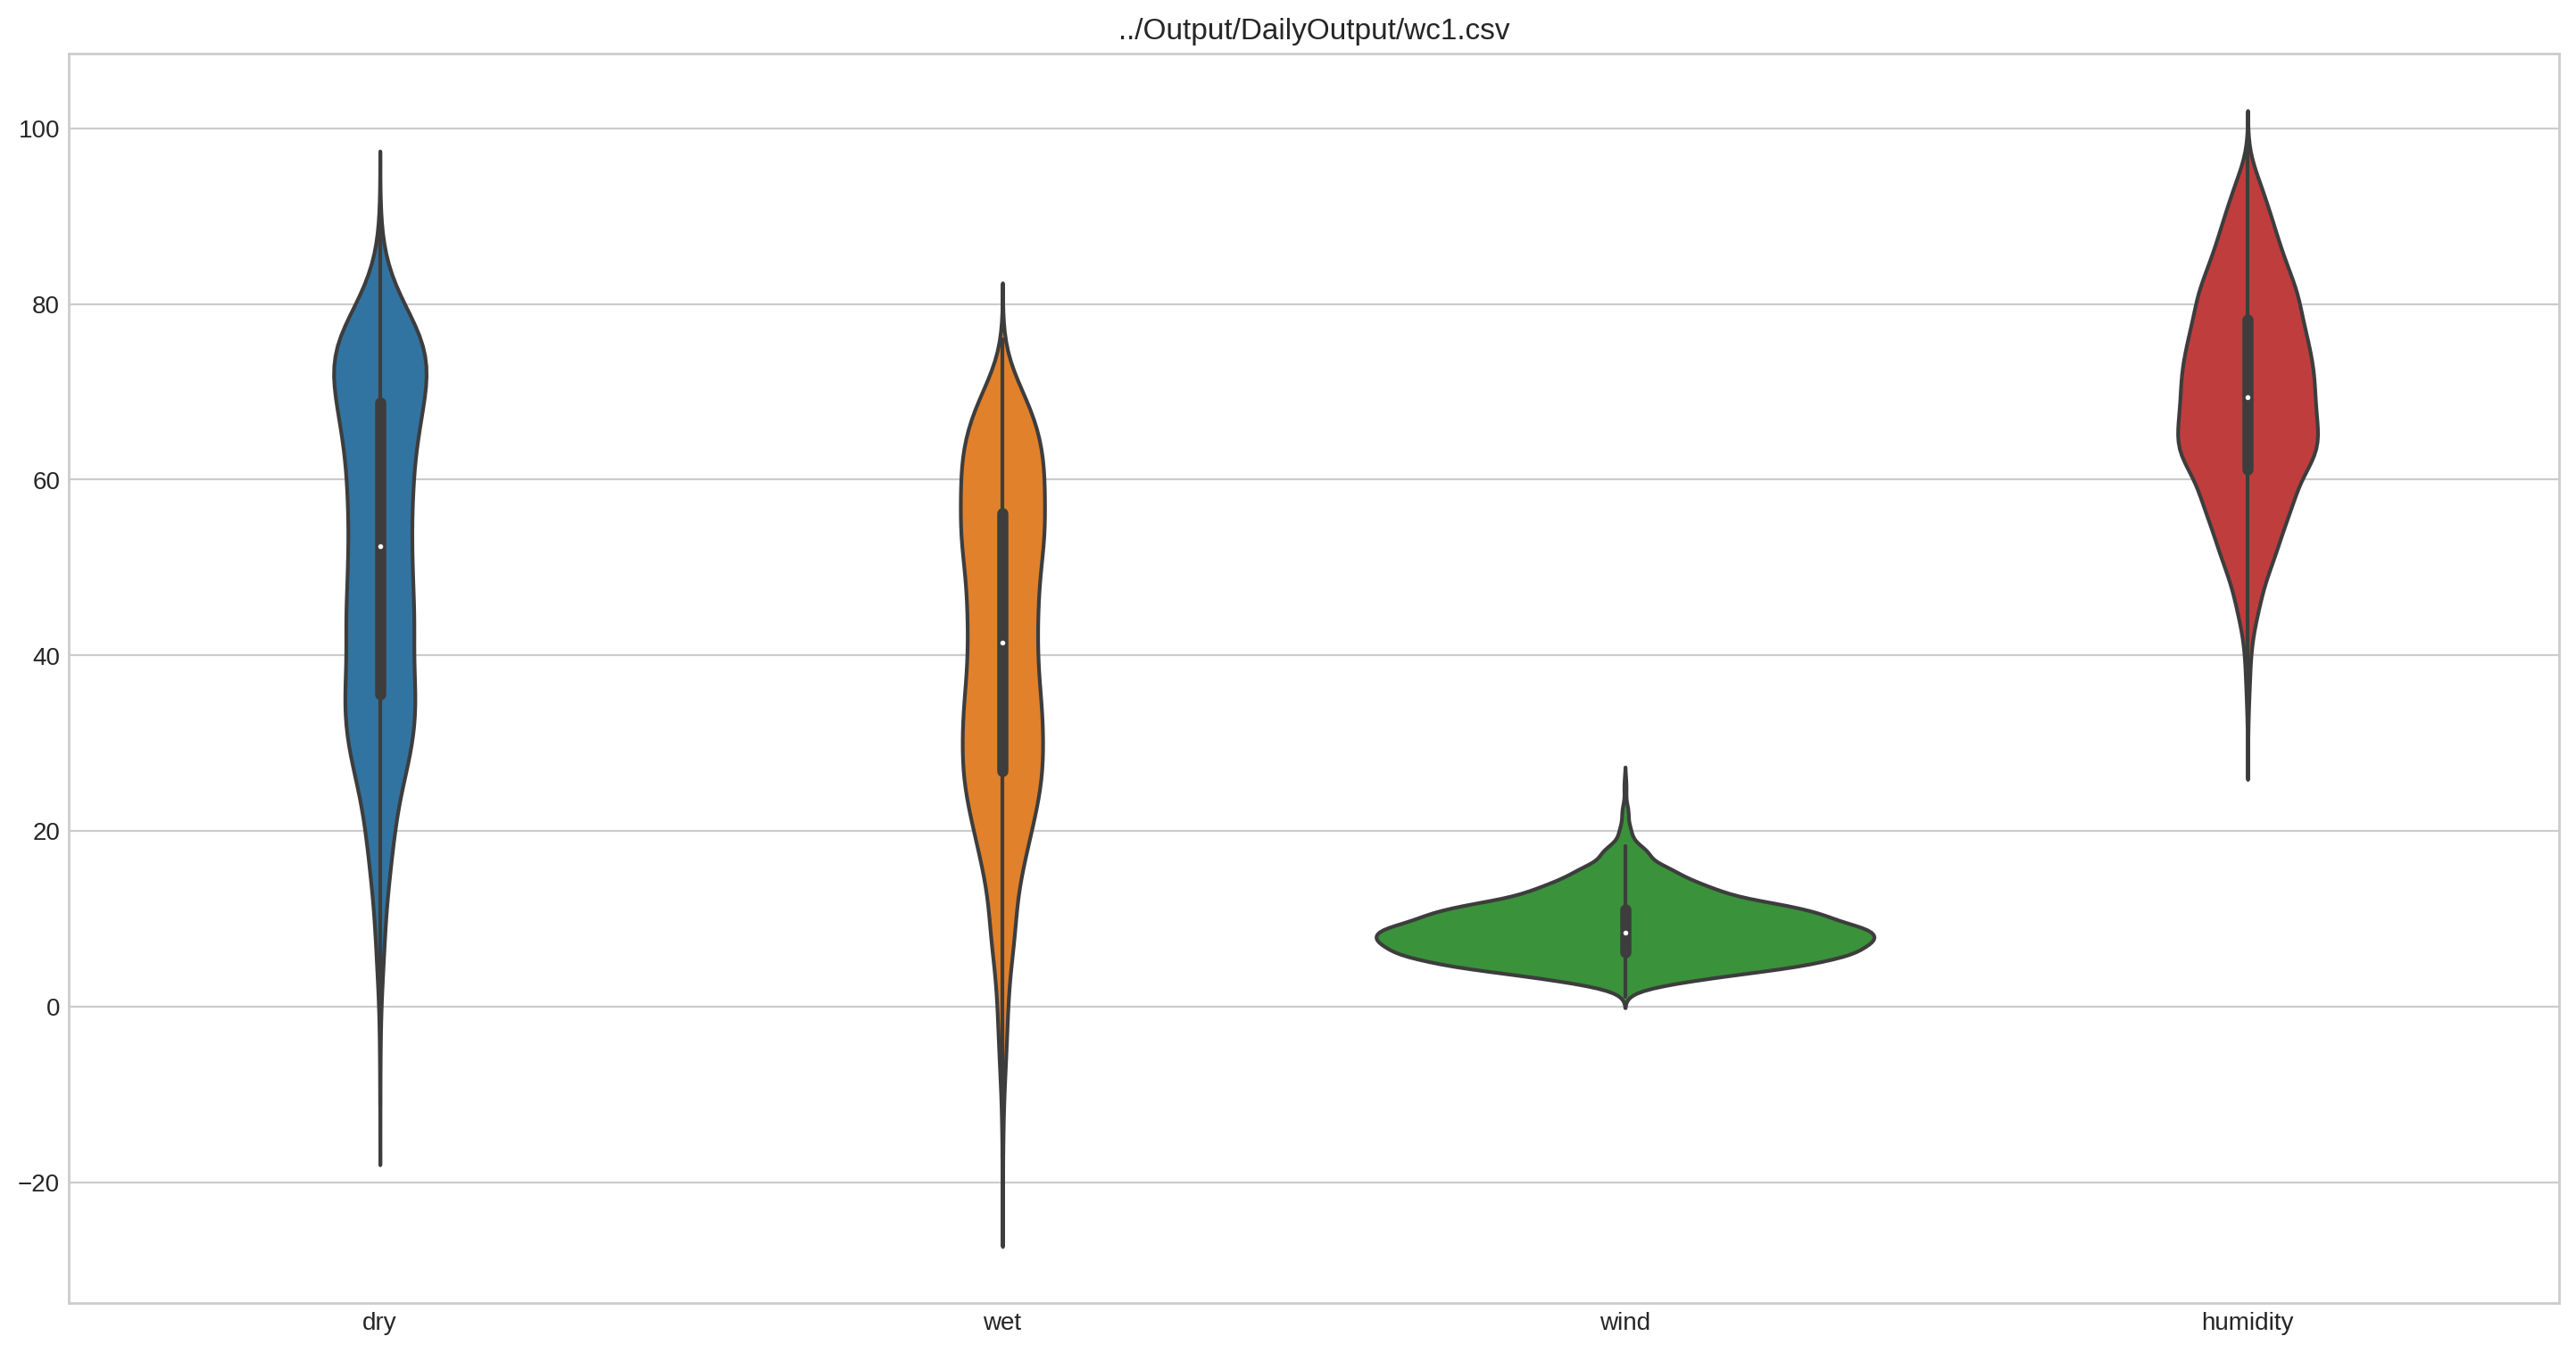

In [3]:
# #############################################################################
# Combination of boxplot and kernel density estimate for Wx data.
# May need to adjust figsize and subplot to fit more graphs.

def violin(num, columns, figheight, subplot_1, subplot_2):
    sns.set_style('whitegrid')
    plt.figure(figsize=(18,figheight))
    for i in range(num):
        plt.subplot(subplot_1,subplot_2,i+1)
        file = '../Output/DailyOutput/wc'+str(i+1)+'.csv'
        weather = pd.read_csv(file, sep=',', low_memory=False, 
                               names = ['date', 'dry', 'wet', 'wind',
                                        'humidity', 'district', 'homicide', 'robbery',
                                        'battery', 'assault', 'burglary', 'theft',
                                        'motor', 'weapons'], usecols = columns)
        plt.title(file)
        sns.violinplot(data=weather)

    plt.show()

NUM_PLOTS = 1
columns = range(1,5)
subplot_1 = 2
subplot_2 = 1
figheight = 20
violin(NUM_PLOTS, columns, figheight, subplot_1, subplot_2)

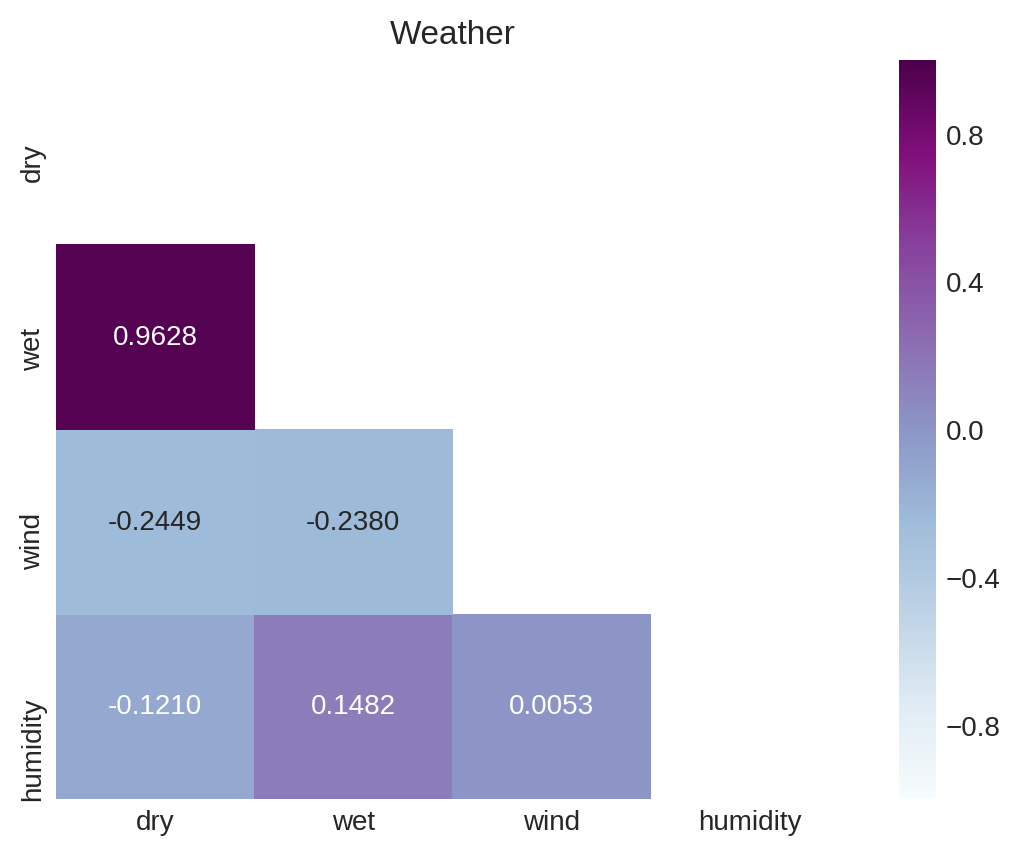

In [4]:
# #############################################################################
# Heatmap from the laster weather set of weather data read
district = '5'

file = '../Output/DailyOutput/wc'+district+'.csv'
weather = pd.read_csv(file, sep=',', low_memory=False, 
                       names = ['date', 'dry', 'wet', 'wind',
                                'humidity', 'district', 'homicide', 'robbery',
                                'battery', 'assault', 'burglary', 'theft',
                                'motor', 'weapons'], usecols = columns)
corr = weather.corr(method='pearson')
mask = np.zeros_like(corr,dtype=np.bool)

# set to False to view full matrix
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, annot=True, fmt='.4f', mask=mask, cmap='BuPu', robust=True)
plt.title('Weather')

plt.show()

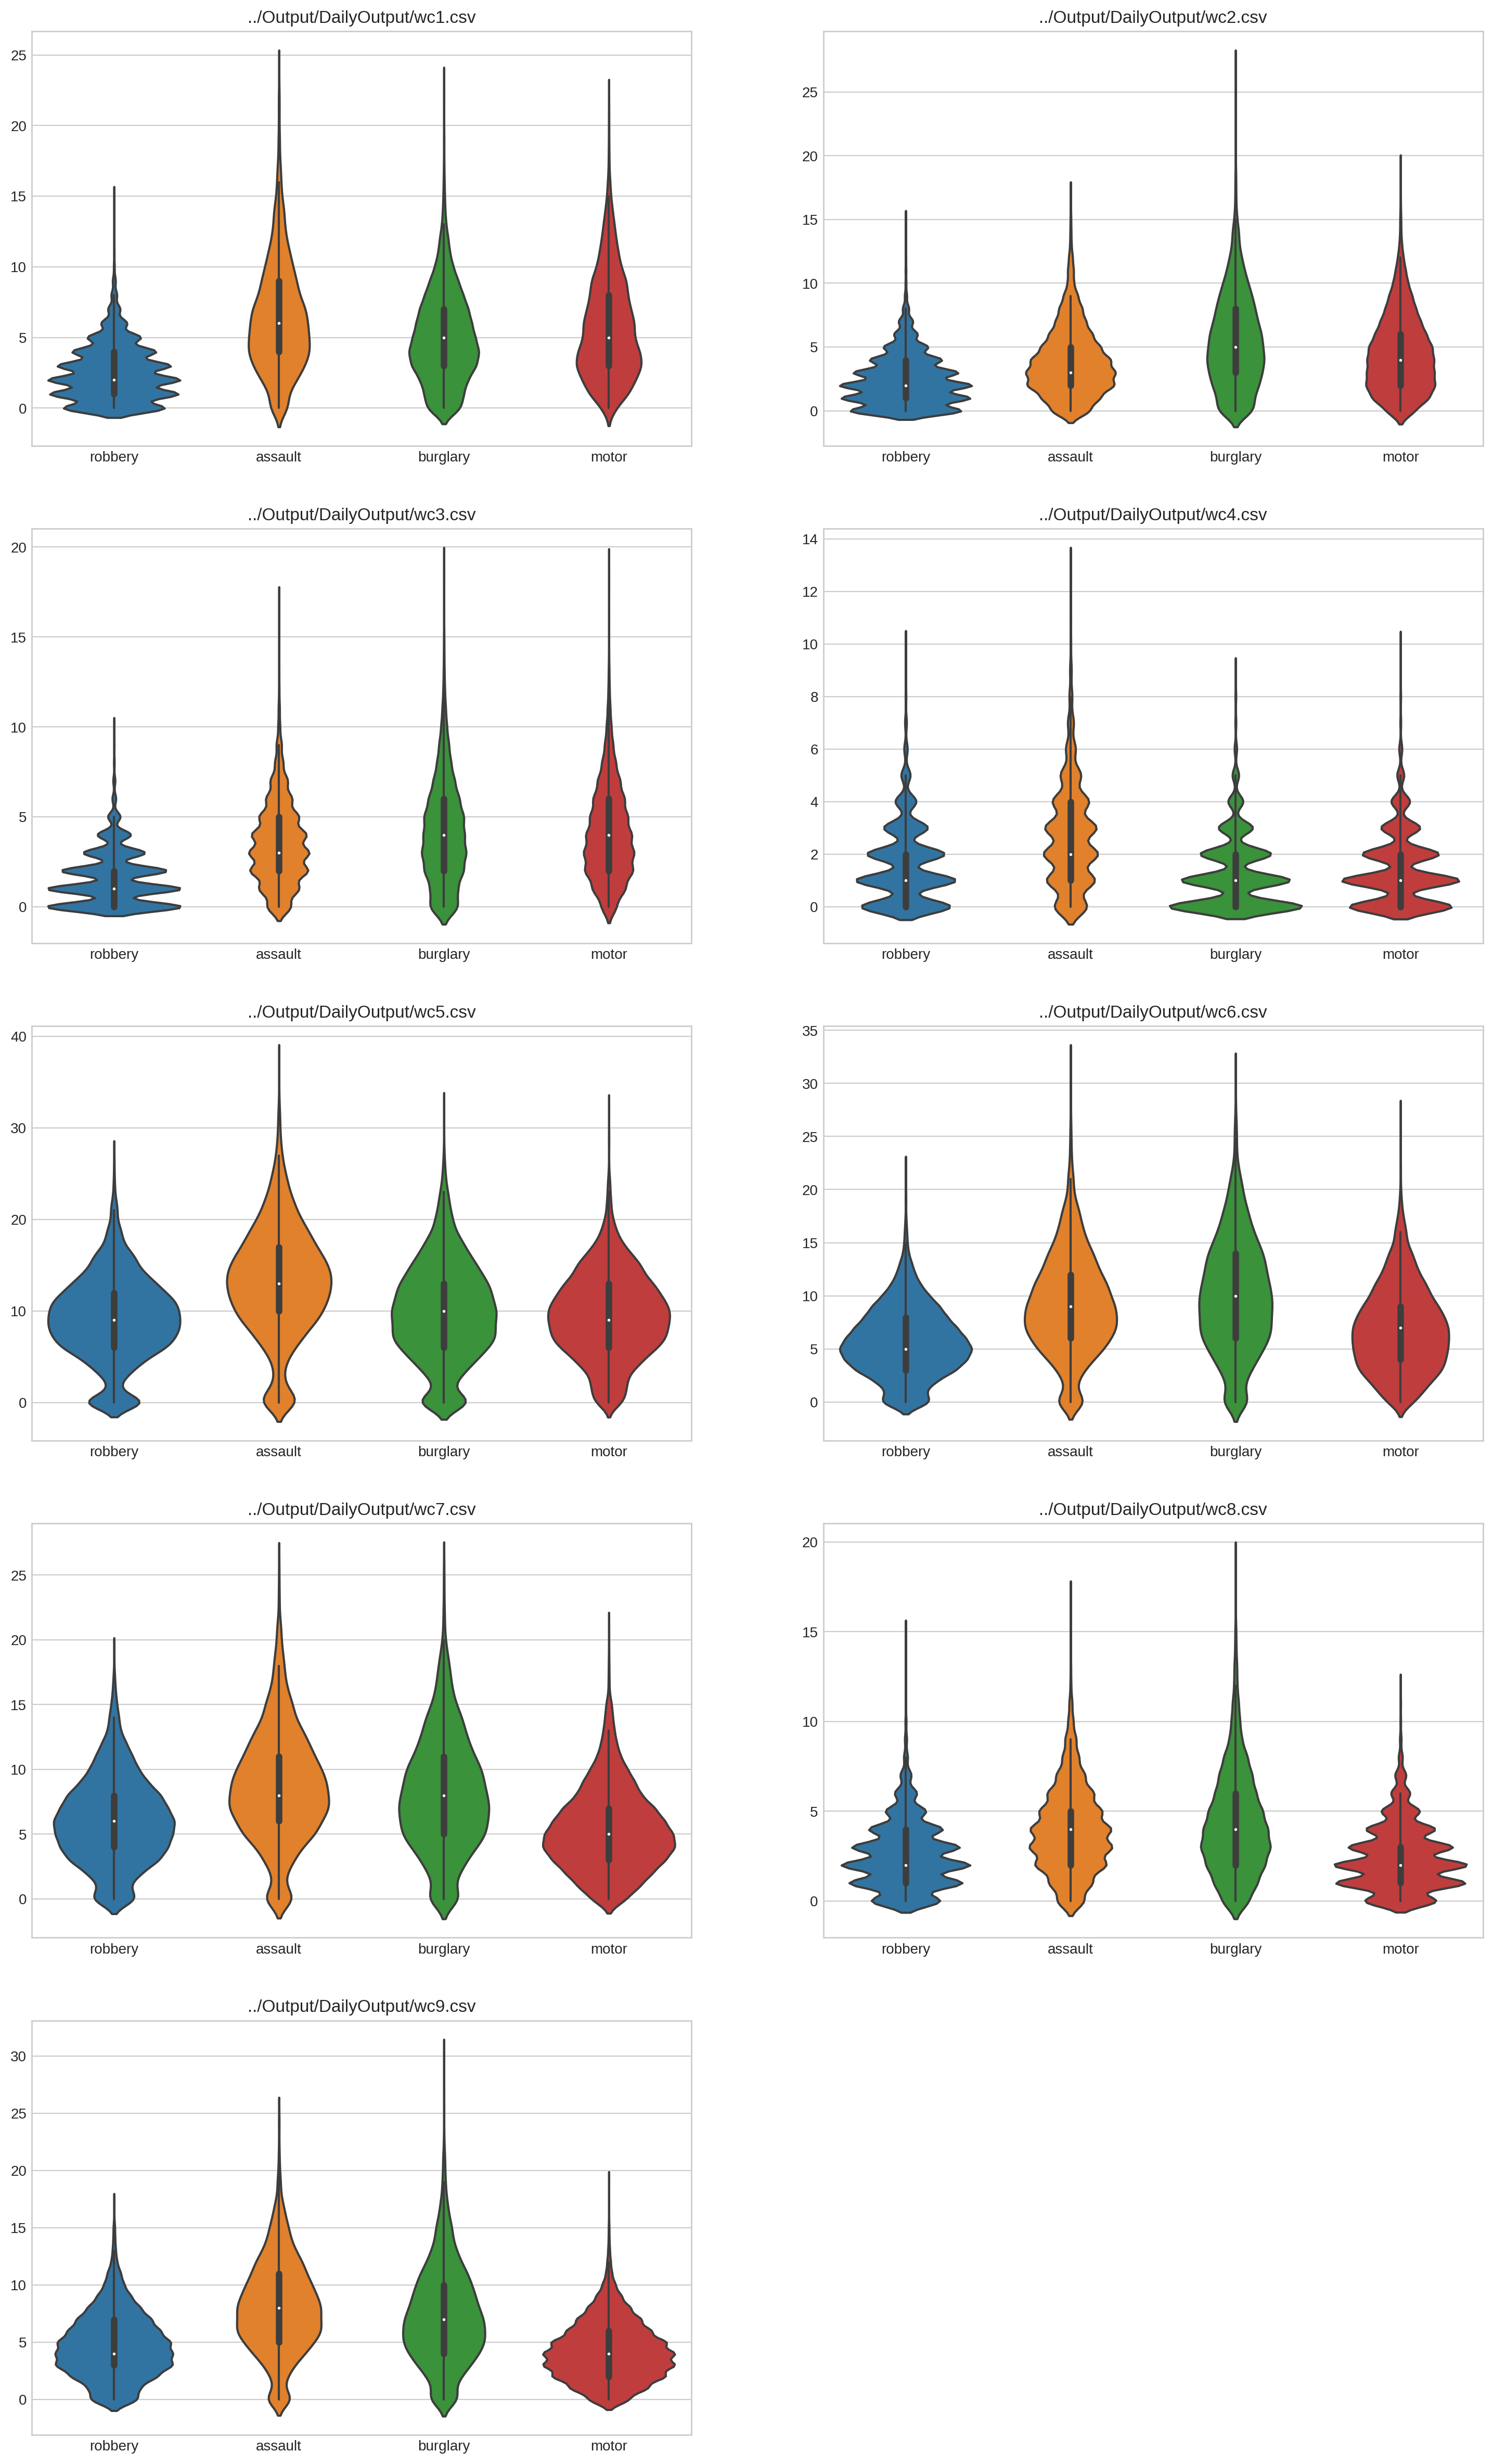

In [5]:
# #############################################################################
# Look at output features (crime) over districts

NUM_PLOTS = 9
columns = [7, 9, 10, 12]
subplot_1 = 5
subplot_2 = 2
figheight = 30
violin(NUM_PLOTS, columns, figheight, subplot_1, subplot_2)

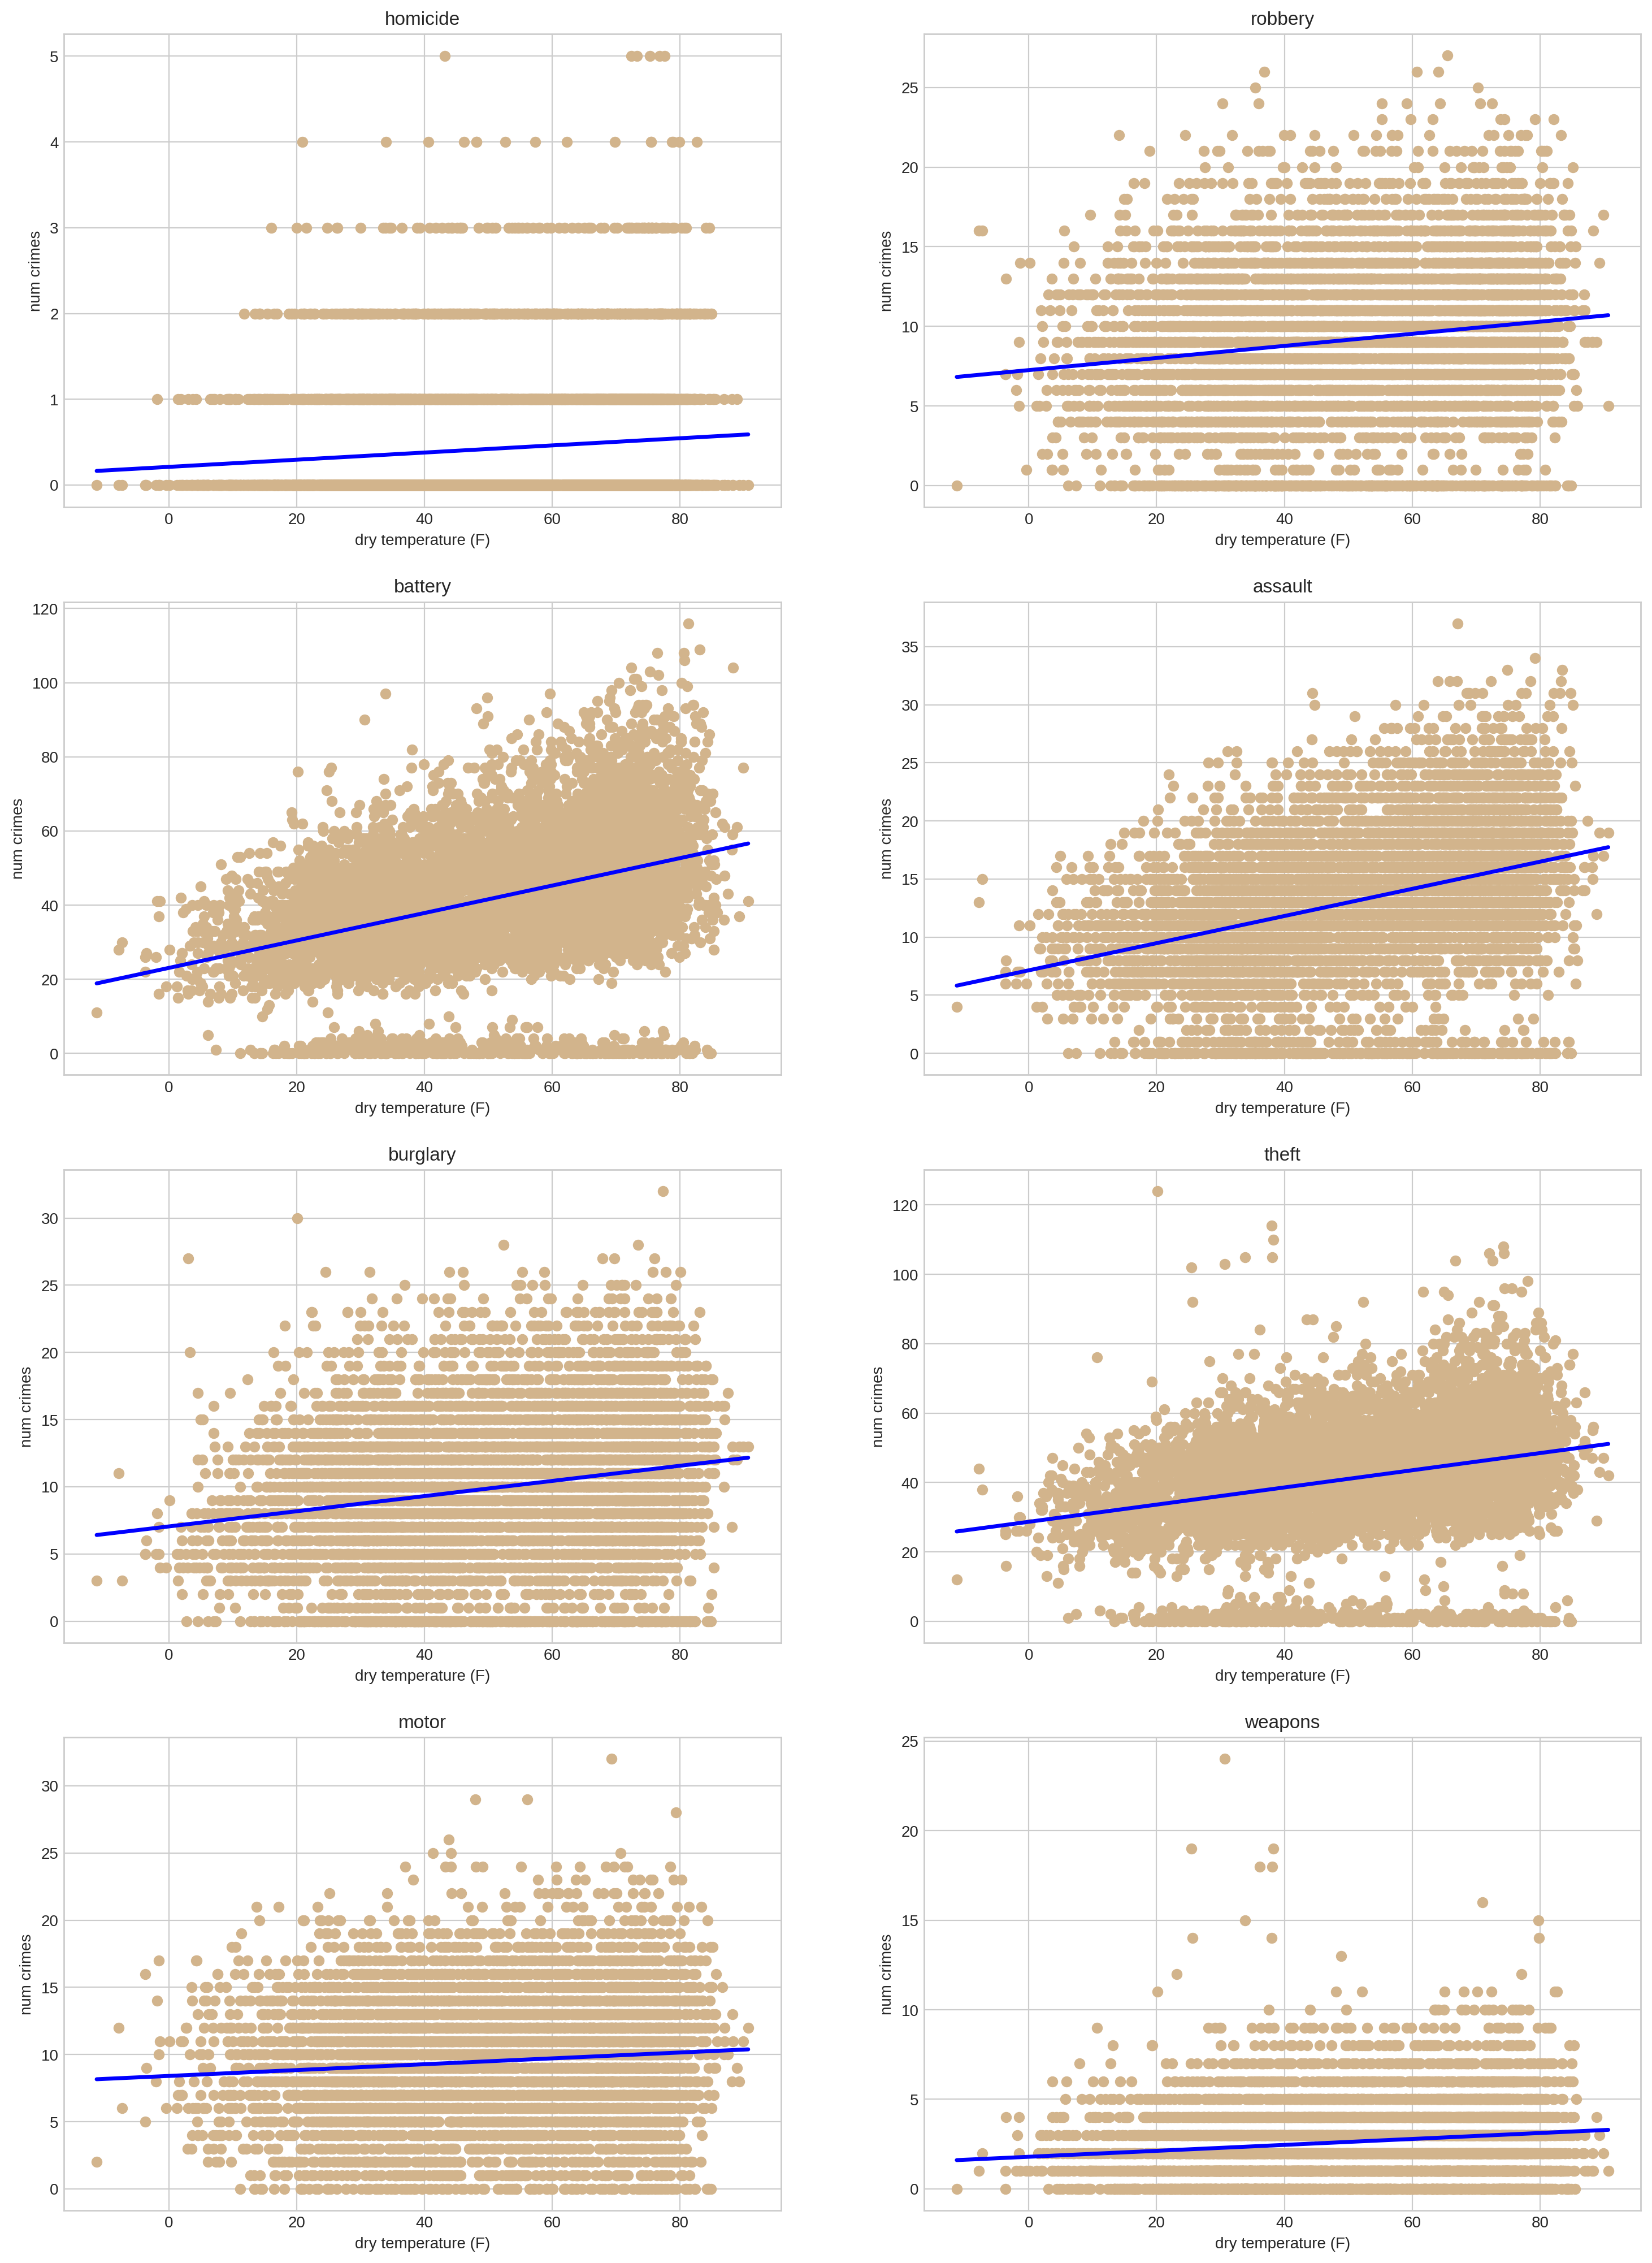

In [6]:
# #############################################################################
# Number of crimes versus dry bulb temperature

def scatter_crime(data):
    col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']
    xAxis = 'dry'
    plt.figure(figsize=(18,25))
    for i in range(len(col)):
        x = data[xAxis]
        y = data[col[i]]
        plt.subplot(4,2,i+1)  
        plt.scatter(x, y, color='tan')
        plt.title(col[i])
        plt.xlabel(xAxis + ' temperature (F)'), plt.ylabel('num crimes')
        plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'b-', lw=2.5)

    plt.show() 

district = '5'
    
data = pd.read_csv('../Output/DailyOutput/wc'+district+'.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])
data['date'] = pd.to_datetime(data.date)
data.sort_values(by='date', inplace=True)
scatter_crime(data)

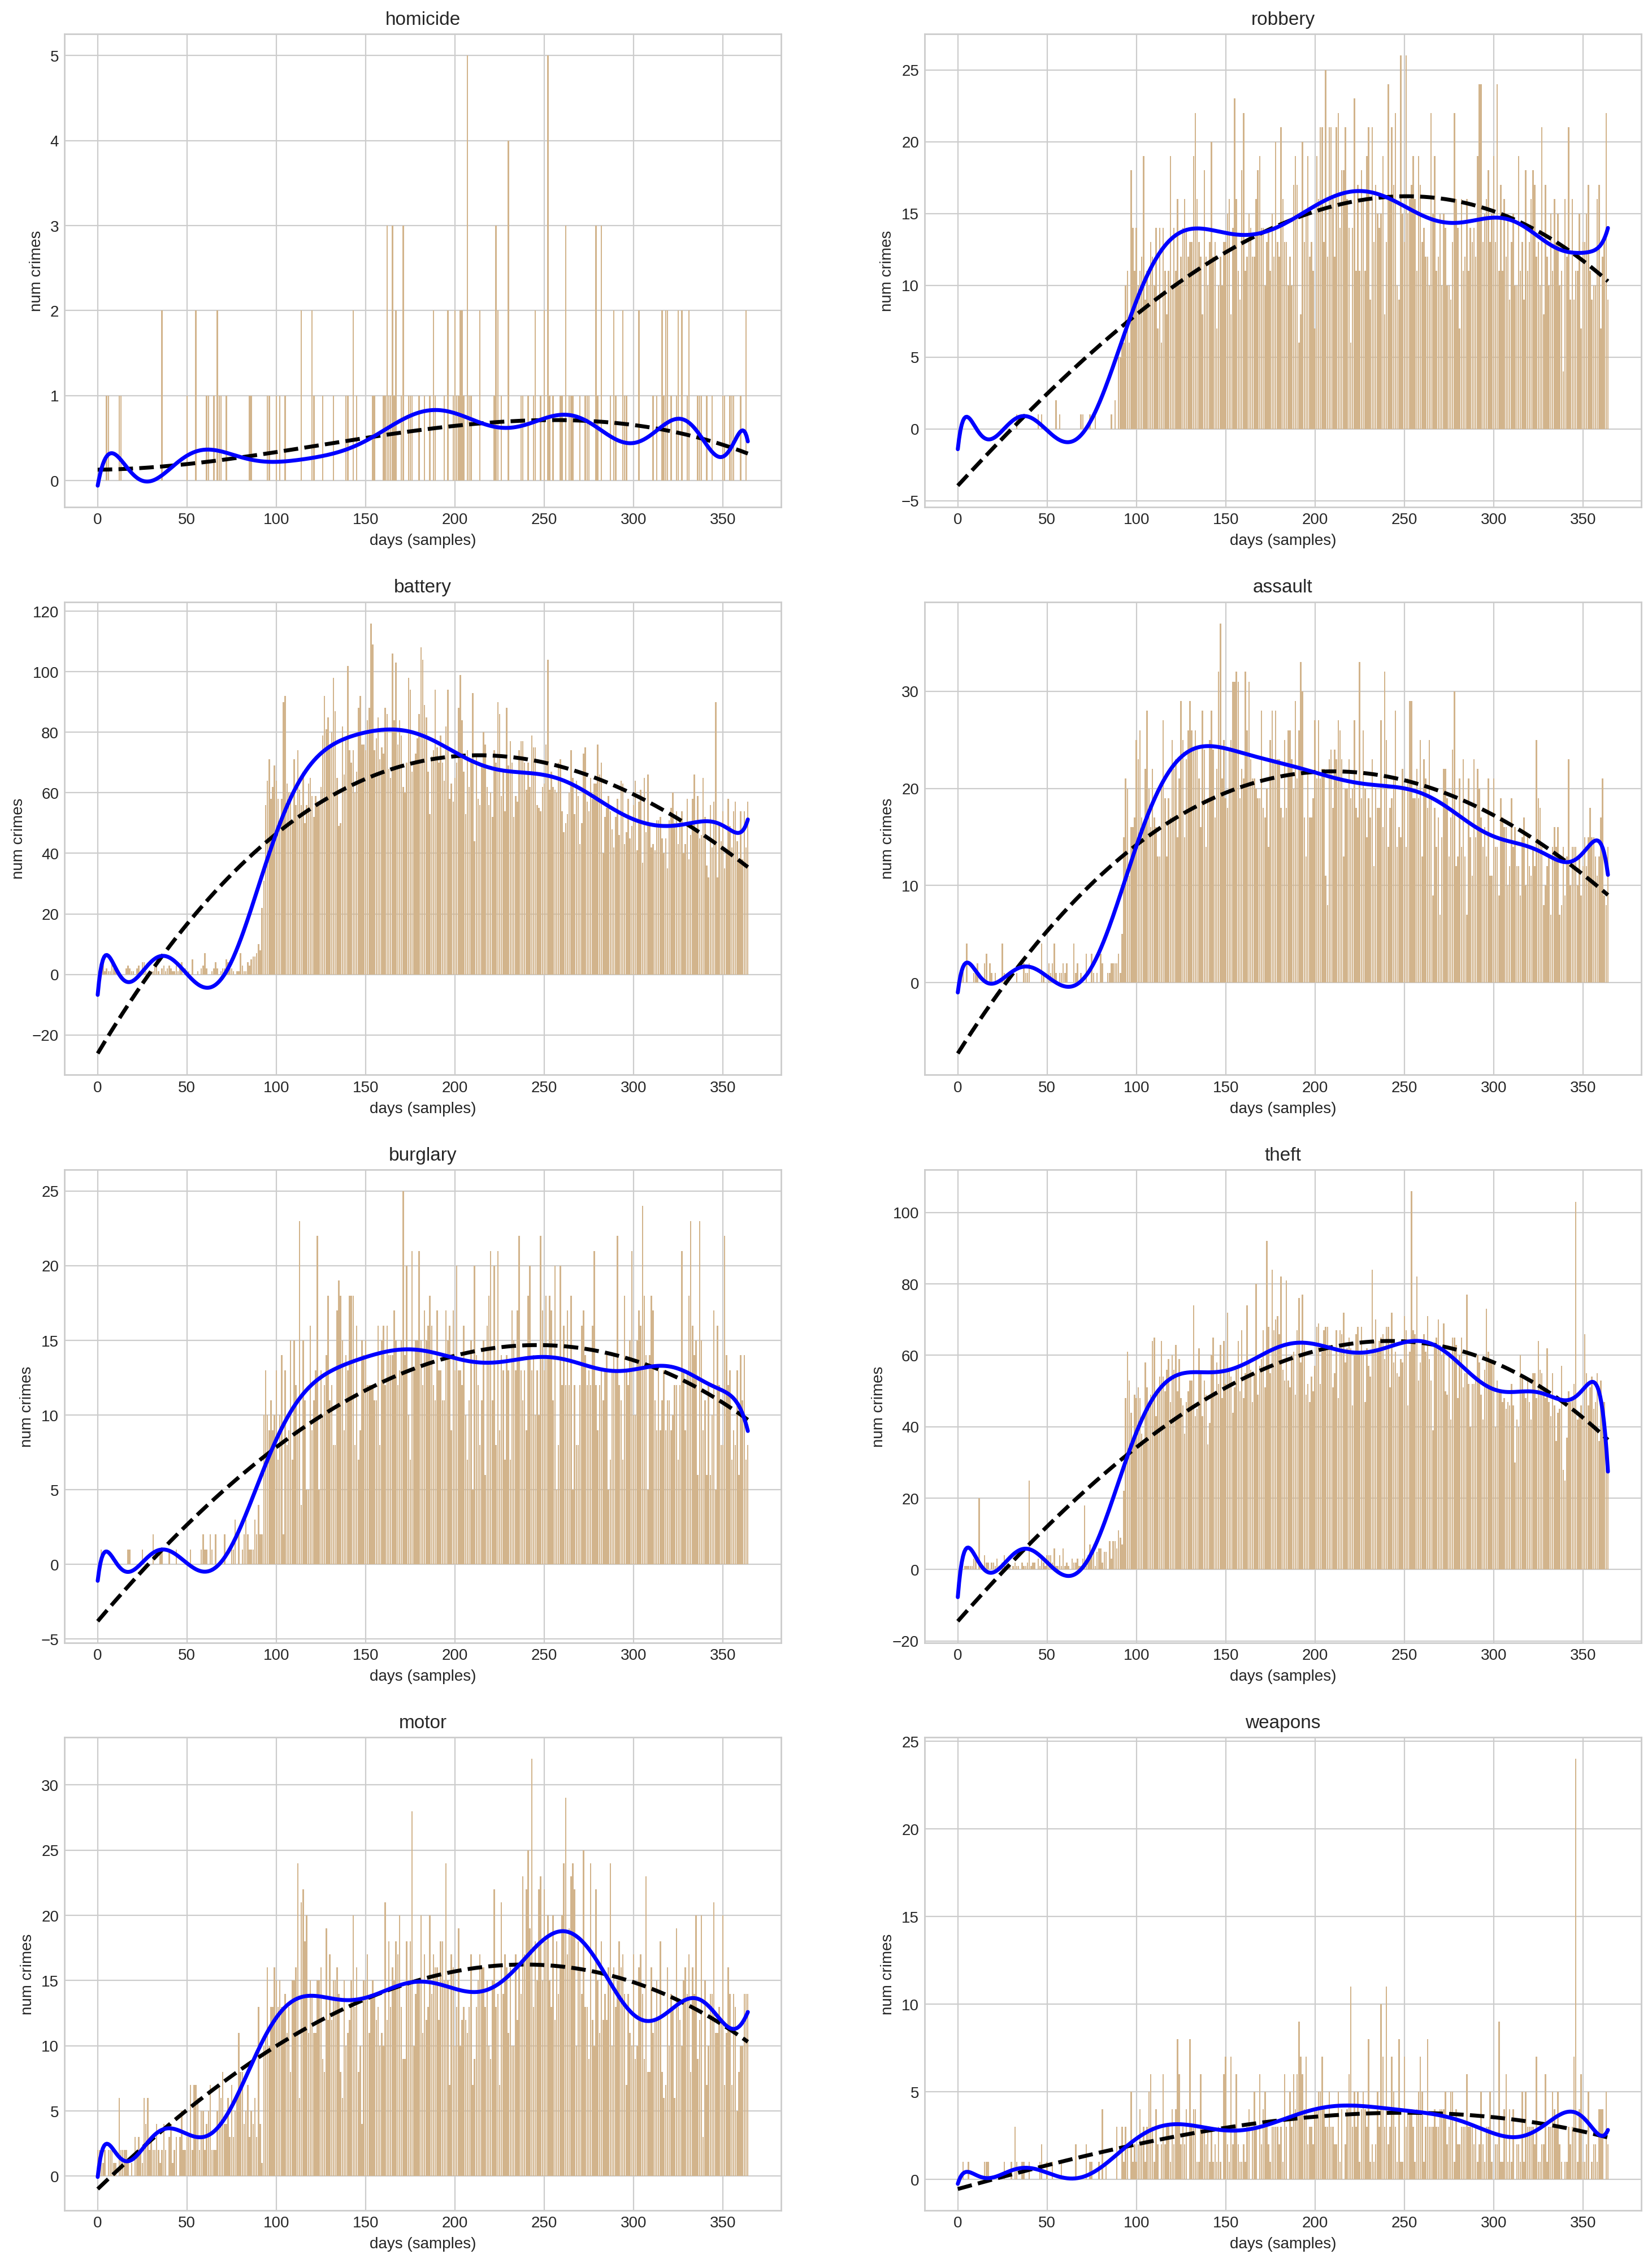

In [7]:
# #############################################################################
# Crimes over time by yearly subsets

def bar_crime(data, year):
    col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']
    plt.figure(figsize=(18,25))
    
    for i in range(len(col)):
        plt.subplot(4,2,i+1)  
        y = data[col[i]][365*(year - 1):365*year]
        x = np.arange(len(y))
        z = np.polyfit(x, y, 3)
        
        p = np.poly1d(z)
        p30 = np.poly1d(np.polyfit(x, y, 15))
        xp = np.linspace(0, len(y) - 1, 500)
        
        plt.bar(x, y, color='tan')
        _ = plt.plot(xp, p(xp), 'k--', xp, p30(xp), 'b-', lw=2.5)
        plt.title(col[i])
        plt.xlabel('days (samples)'), plt.ylabel('num crimes') 
        
    plt.show() 

# Adjust year and district, 1-17 and 1-9 respectively

year = 2
district = '5'

data = pd.read_csv('../Output/DailyOutput/wc'+district+'.csv', sep=',', low_memory=False, 
               names = ['date', 'dry', 'wet', 'wind',
                        'humidity', 'district', 'homicide', 'robbery',
                        'battery', 'assault', 'burglary', 'theft',
                        'motor', 'weapons'])

data['date'] = pd.to_datetime(data.date)
data.sort_values(by='date', inplace=True)

bar_crime(data, year)

In [19]:
# #############################################################################
# Read in data for rest of experiments

district = '5'

data = pd.read_csv('../output/DailyOutput/wc'+district+'.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])
data['date'] = pd.to_datetime(data.date)
data.sort_values(by='date', inplace=True)
data = data.iloc[70*7:]

In [20]:
# #############################################################################
# Sample the data

data.head()

date        dry        wet      wind   humidity  district  \
2592 2002-05-25  50.985294  46.308824  9.470588  84.647059         5   
2610 2002-05-26  59.634615  44.500000  7.903846  62.346154         5   
2628 2002-05-27  66.076923  49.807692  6.057692  57.365385         5   
2646 2002-05-28  67.942308  57.634615  5.750000  70.211538         5   
2664 2002-05-29  73.568627  61.352941  8.411765  67.647059         5   

      homicide  robbery  battery  assault  burglary  theft  motor  weapons  
2592         0       12       62       29        13     48     16        2  
2610         1       14       79       25        10     46      9        3  
2628         0       16       92       15        12     38      8        2  
2646         0       14       81       23        14     47     19        4  
2664         0       12       85       26        18     50     12        0

In [21]:
# #############################################################################
# Check for NaN / Missing values and dtype

data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5983 entries, 2592 to 5080
Data columns (total 14 columns):
date        5983 non-null datetime64[ns]
dry         5983 non-null float64
wet         5983 non-null float64
wind        5983 non-null float64
humidity    5983 non-null float64
district    5983 non-null int64
homicide    5983 non-null int64
robbery     5983 non-null int64
battery     5983 non-null int64
assault     5983 non-null int64
burglary    5983 non-null int64
theft       5983 non-null int64
motor       5983 non-null int64
weapons     5983 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(9)
memory usage: 701.1 KB


In [22]:
# #############################################################################
# Descriptive statistics that summarize the central tendency, 
# dispersion and shape of the entire data distribution

data.describe()

dry          wet         wind     humidity  district  \
count  5983.000000  5983.000000  5983.000000  5983.000000    5983.0   
mean     51.541291    40.724899     8.714548    69.345863       5.0   
std      19.605183    18.665742     3.632796    11.897241       0.0   
min     -11.280255   -20.910828     1.125000    30.000000       5.0   
25%      35.788968    26.935284     6.000000    61.153606       5.0   
50%      52.981818    41.835526     8.289474    69.282895       5.0   
75%      69.020208    56.476409    10.914133    78.104326       5.0   
max      90.684211    76.000000    26.016949    97.800000       5.0   

          homicide      robbery      battery      assault     burglary  \
count  5983.000000  5983.000000  5983.000000  5983.000000  5983.000000   
mean      0.426876     9.880996    45.039612    14.061675    10.684606   
std       0.704117     3.956113    15.442539     5.084940     4.767546   
min       0.000000     0.000000    10.000000     1.000000     0.000000   
25%       0.000000     7.000000    34.000000    10.000000     7.000000   
50%       0.000000    10.000000    43.000000    14.000000    10.000000   
75%       1.000000    12.000000    54.000000    17.000000    14.000000   
max       5.000000    27.000000   116.000000    37.000000    32.000000   

             theft        motor      weapons  
count  5983.000000  5983.000000  5983.000000  
mean     44.350326    10.112318     2.829851  
std      12.683015     4.170483     2.057953  
min       9.000000     0.000000     0.000000  
25%      36.000000     7.000000     1.000000  
50%      43.000000    10.000000     3.000000  
75%      51.000000    13.000000     4.000000  
max     124.000000    32.000000    24.000000

### Neural Network

Using SGD from Dr. Anderson by use of the NN package.

In [23]:
# #############################################################################
# Normalize the data

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [24]:
# #############################################################################
# Read in X and T by items in a list, e.g., [2, 3, 5], range(5), etc.

def sampler(data, a, b):
    
    X = data.iloc[:, np.r_[a]]
    T = data.iloc[:, np.r_[b]]
        
    return np.array(X), np.array(T)

X, T = sampler(data, [1,2], range(6,14)) # 6,14

In [25]:
X[:5], T[:5]

(array([[0.6106593 , 0.69362375],
        [0.69548612, 0.67495892],
        [0.75866801, 0.72972775],
        [0.77696247, 0.81049192],
        [0.83214169, 0.84886045]]), array([[ 0, 12, 62, 29, 13, 48, 16,  2],
        [ 1, 14, 79, 25, 10, 46,  9,  3],
        [ 0, 16, 92, 15, 12, 38,  8,  2],
        [ 0, 14, 81, 23, 14, 47, 19,  4],
        [ 0, 12, 85, 26, 18, 50, 12,  0]]))

In [26]:
# #############################################################################
# Return predicted values from training and running

def get_values(X, T, network, train_f, itr, partition = False):
    if partition: 
        Xtrain, Ttrain, Xtest, T = ml.partition(X, T, (train_f, 1 - train_f))
        
        nnet = nn.NeuralNetwork(Xtrain.shape[1], network, Ttrain.shape[1])
        nnet.train(Xtrain, Ttrain, itr)
        Y = nnet.use(Xtest)
        
    else:  
        nnet = nn.NeuralNetwork(X.shape[1], network, T.shape[1]) 
        nnet.train(X, T, itr)
        Y = nnet.use(X)
        
    return Y, T, nnet.getErrorTrace()

Network 1: [54] with 1200 iterations.
Network 2: [67, 67] with 1260 iterations.
Network 3: [4] with 1323 iterations.
Network 4: [12, 12, 12, 12, 12] with 1389 iterations.
Network 5: [38, 38, 38] with 1458 iterations.
Network 6: [10, 10, 10] with 1530 iterations.
Network 7: [33, 33, 33, 33] with 1606 iterations.
Network 8: [31, 31, 31, 31, 31] with 1686 iterations.
Network 9: [63, 63] with 1770 iterations.
Network 10: [53, 53, 53, 53, 53] with 1858 iterations.
Network 11: [60, 60, 60, 60, 60] with 1950 iterations.
Network 12: [16] with 2047 iterations.
Network 13: [51, 51, 51] with 2149 iterations.
Network 14: [18, 18, 18, 18, 18] with 2256 iterations.
Network 15: [40, 40, 40, 40] with 2368 iterations.
Network 16: [16, 16] with 2486 iterations.
Network 17: [38, 38] with 2610 iterations.
Network 18: [19, 19, 19, 19] with 2740 iterations.
Network 19: [26, 26, 26, 26, 26] with 2877 iterations.
Network 20: [59, 59, 59, 59] with 3020 iterations.


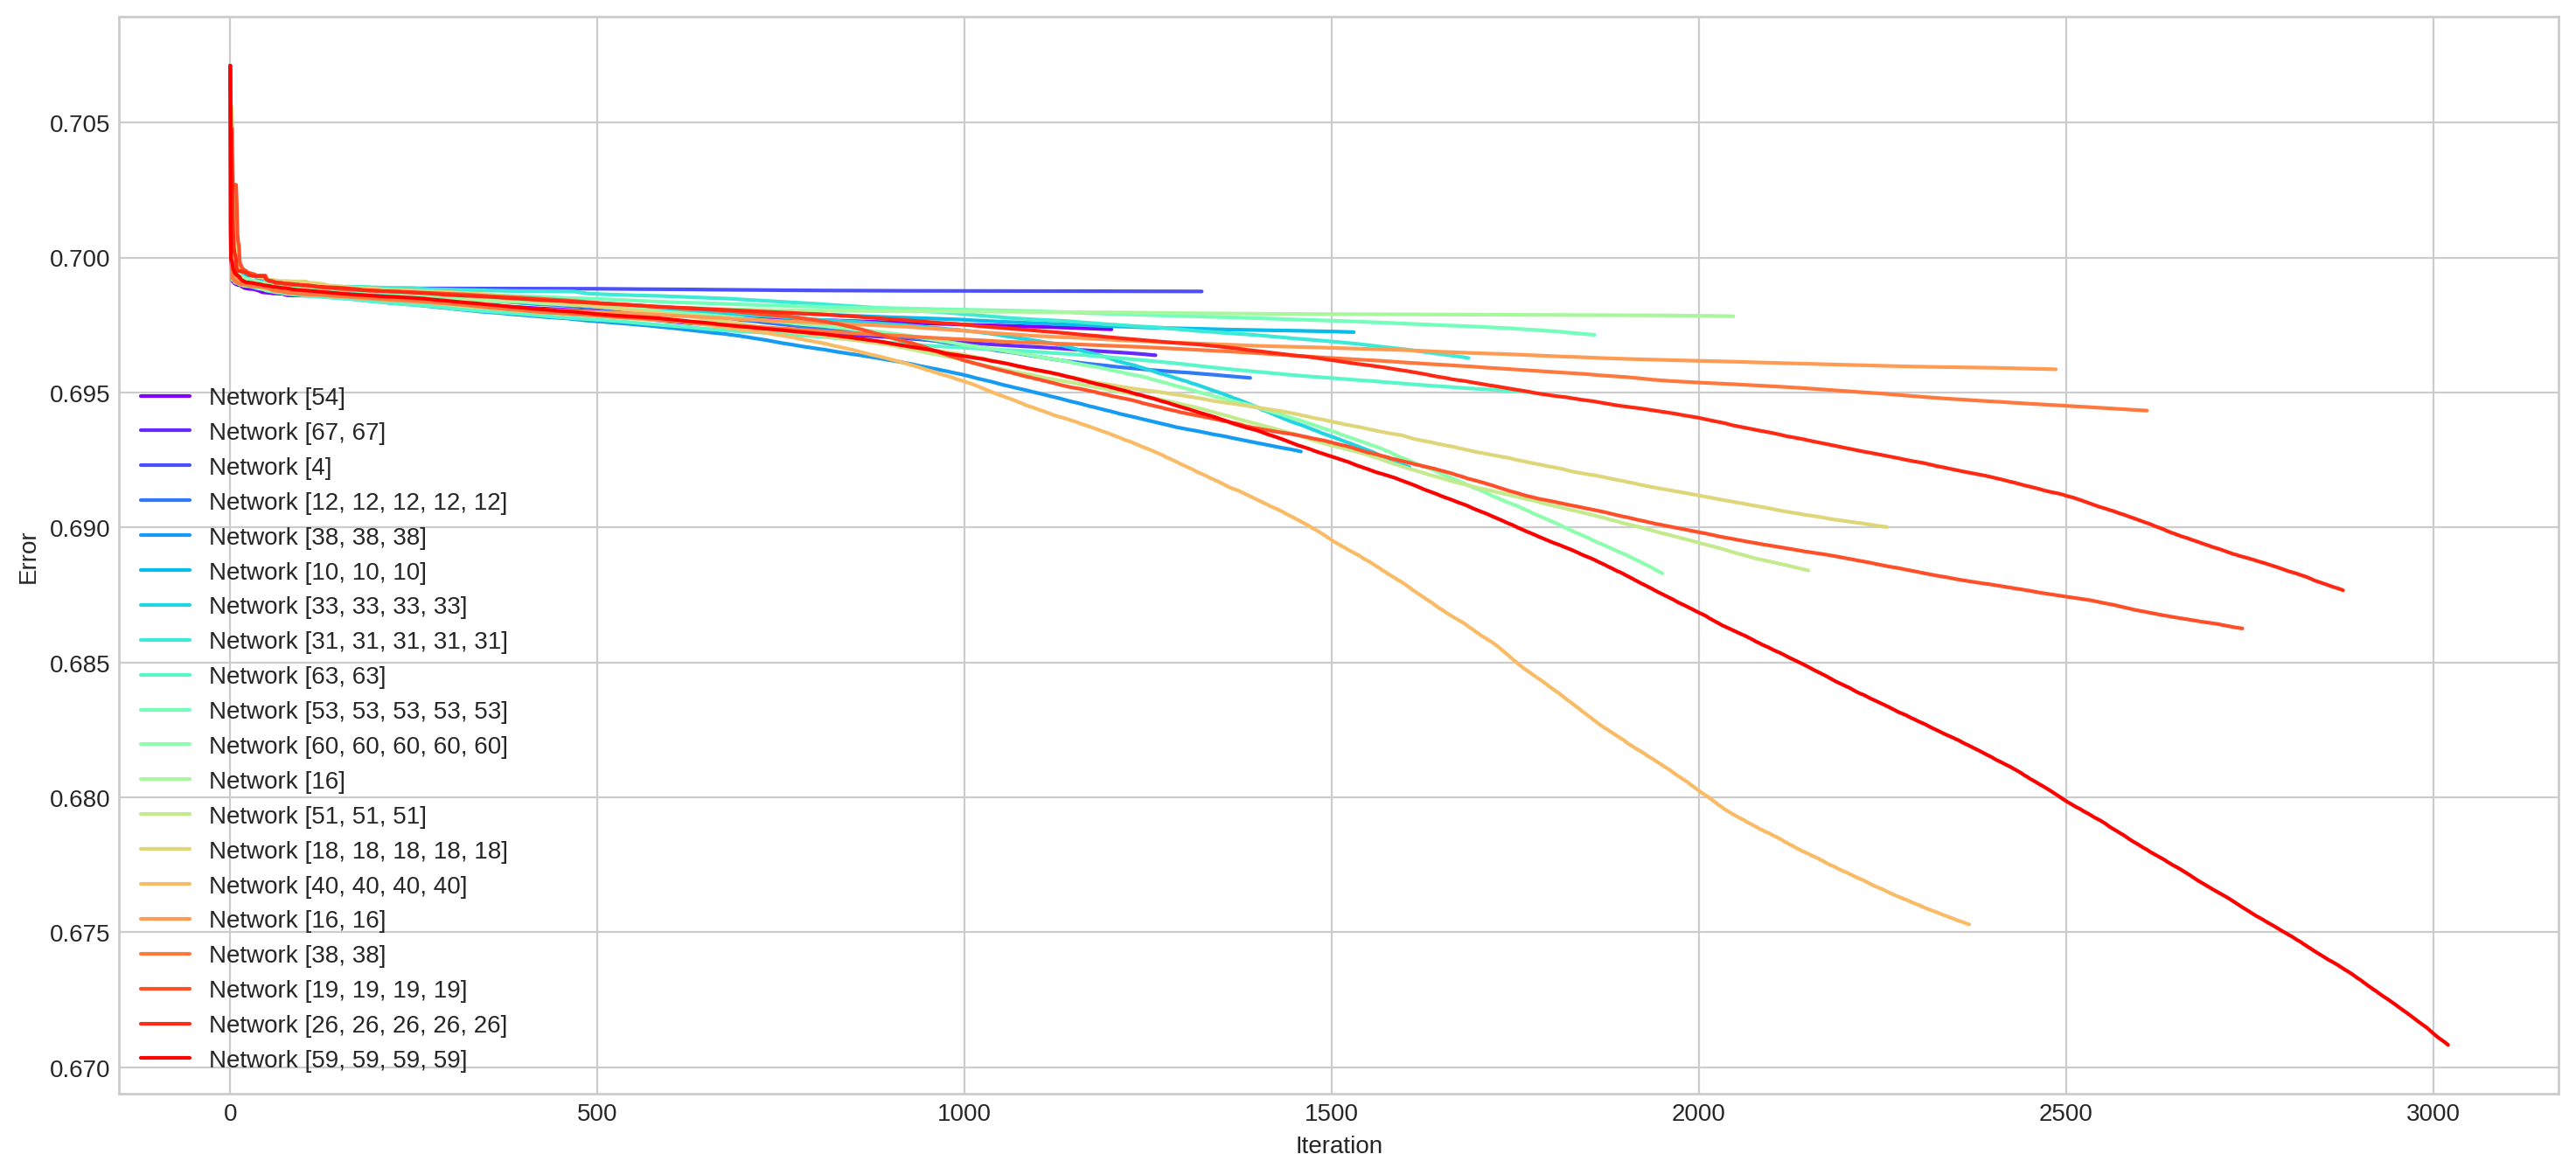

In [16]:
# #############################################################################
# Look at Error / Network / Iterations

sns.set_style("whitegrid")

numberItr = 1200
train_f = 0.8
er = []
networks = []
for i in range(20):
    a = np.random.randint(1, 75)
    b = np.random.randint(1, 6)
    print('Network', str(i+1) + ':', [a]*b,
          'with', numberItr, 'iterations.')

    Y, _T, error = get_values(X, T, [a]*b, train_f, numberItr)
    er.append(error)
    networks.append([a]*b)
    numberItr = int(1.05 * numberItr)

color=iter(cm.rainbow(np.linspace(0,1,20)))
plt.figure(figsize=(18,8))
for i, pl in enumerate(er):
    plt.plot(pl, c=next(color), label = 'Network '+str(networks[i]))

plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()

In [17]:
# #############################################################################
# Deeper network.  Found no difference when running.

'''
numberItr = 500
er = []

for i in range(14):
    a = np.random.randint(1, 50)
    b = np.random.randint(5, 20)
    print('Network', str(i+1) + ':', [a]*b,
          'with', numberItr, 'iterations.')

    Y, _T, error = get_values(X, T, [a]*b, train_f, numberItr)
    er.append(error)
    numberItr = int(1.15 * numberItr)

plt.figure(figsize=(18,6))
for i, pl in enumerate(er):
    plt.plot(pl, label = 'Network '+str(i+1))

plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.show()
'''
print('check')

check


In [27]:
# #############################################################################
# Retrieve the best NN structure.  
# Best seen [67, 67, 67, 67] 2000 80/20 District 4
# MIN ERROR 0.49223388006888474, RMSE: 33.93454955140849
# [72, 72, 72, 72]
# ERROR MIN: 0.46960927770591065, RMSE: 35.984220552712344

itr = 300
hidden = []
trainFraction = 0.80
numberRepetitions = 2

for i in range(5):
    a = np.random.randint(35, 75)
    b = np.random.randint(3, 6)
    hidden.append([a]*b)

results = trainNNs(X, T, trainFraction, hidden,
                   numberRepetitions, itr)
summary = summarize(results)
best    = bestNetwork(summary)

pprint(summary)
printBest(best)

[[[40, 40, 40, 40, 40],
  7.011305233793357,
  7.192818119328164,
  12.91283893585205],
 [[53, 53, 53, 53, 53],
  7.039065569982356,
  7.084120078874607,
  21.243428945541382],
 [[47, 47, 47, 47, 47], 7.050217144624215, 7.03594662749753, 17.99198818206787],
 [[43, 43, 43], 7.018824515592563, 7.114244842116689, 9.398192167282104],
 [[37, 37, 37, 37, 37],
  7.022815363031786,
  7.138246531689332,
  13.213327884674072]]

Best: [[47, 47, 47, 47, 47], 7.050217144624215, 7.03594662749753, 17.99198818206787]

Hidden Layers [47, 47, 47, 47, 47] Average Training 7.05 Testing 7.04 Took 17.9920 seconds


Network: [47, 47, 47, 47, 47]
ERROR MIN: 0.67323548936271 for 300 iterations
RMSE: 7.161935540228529


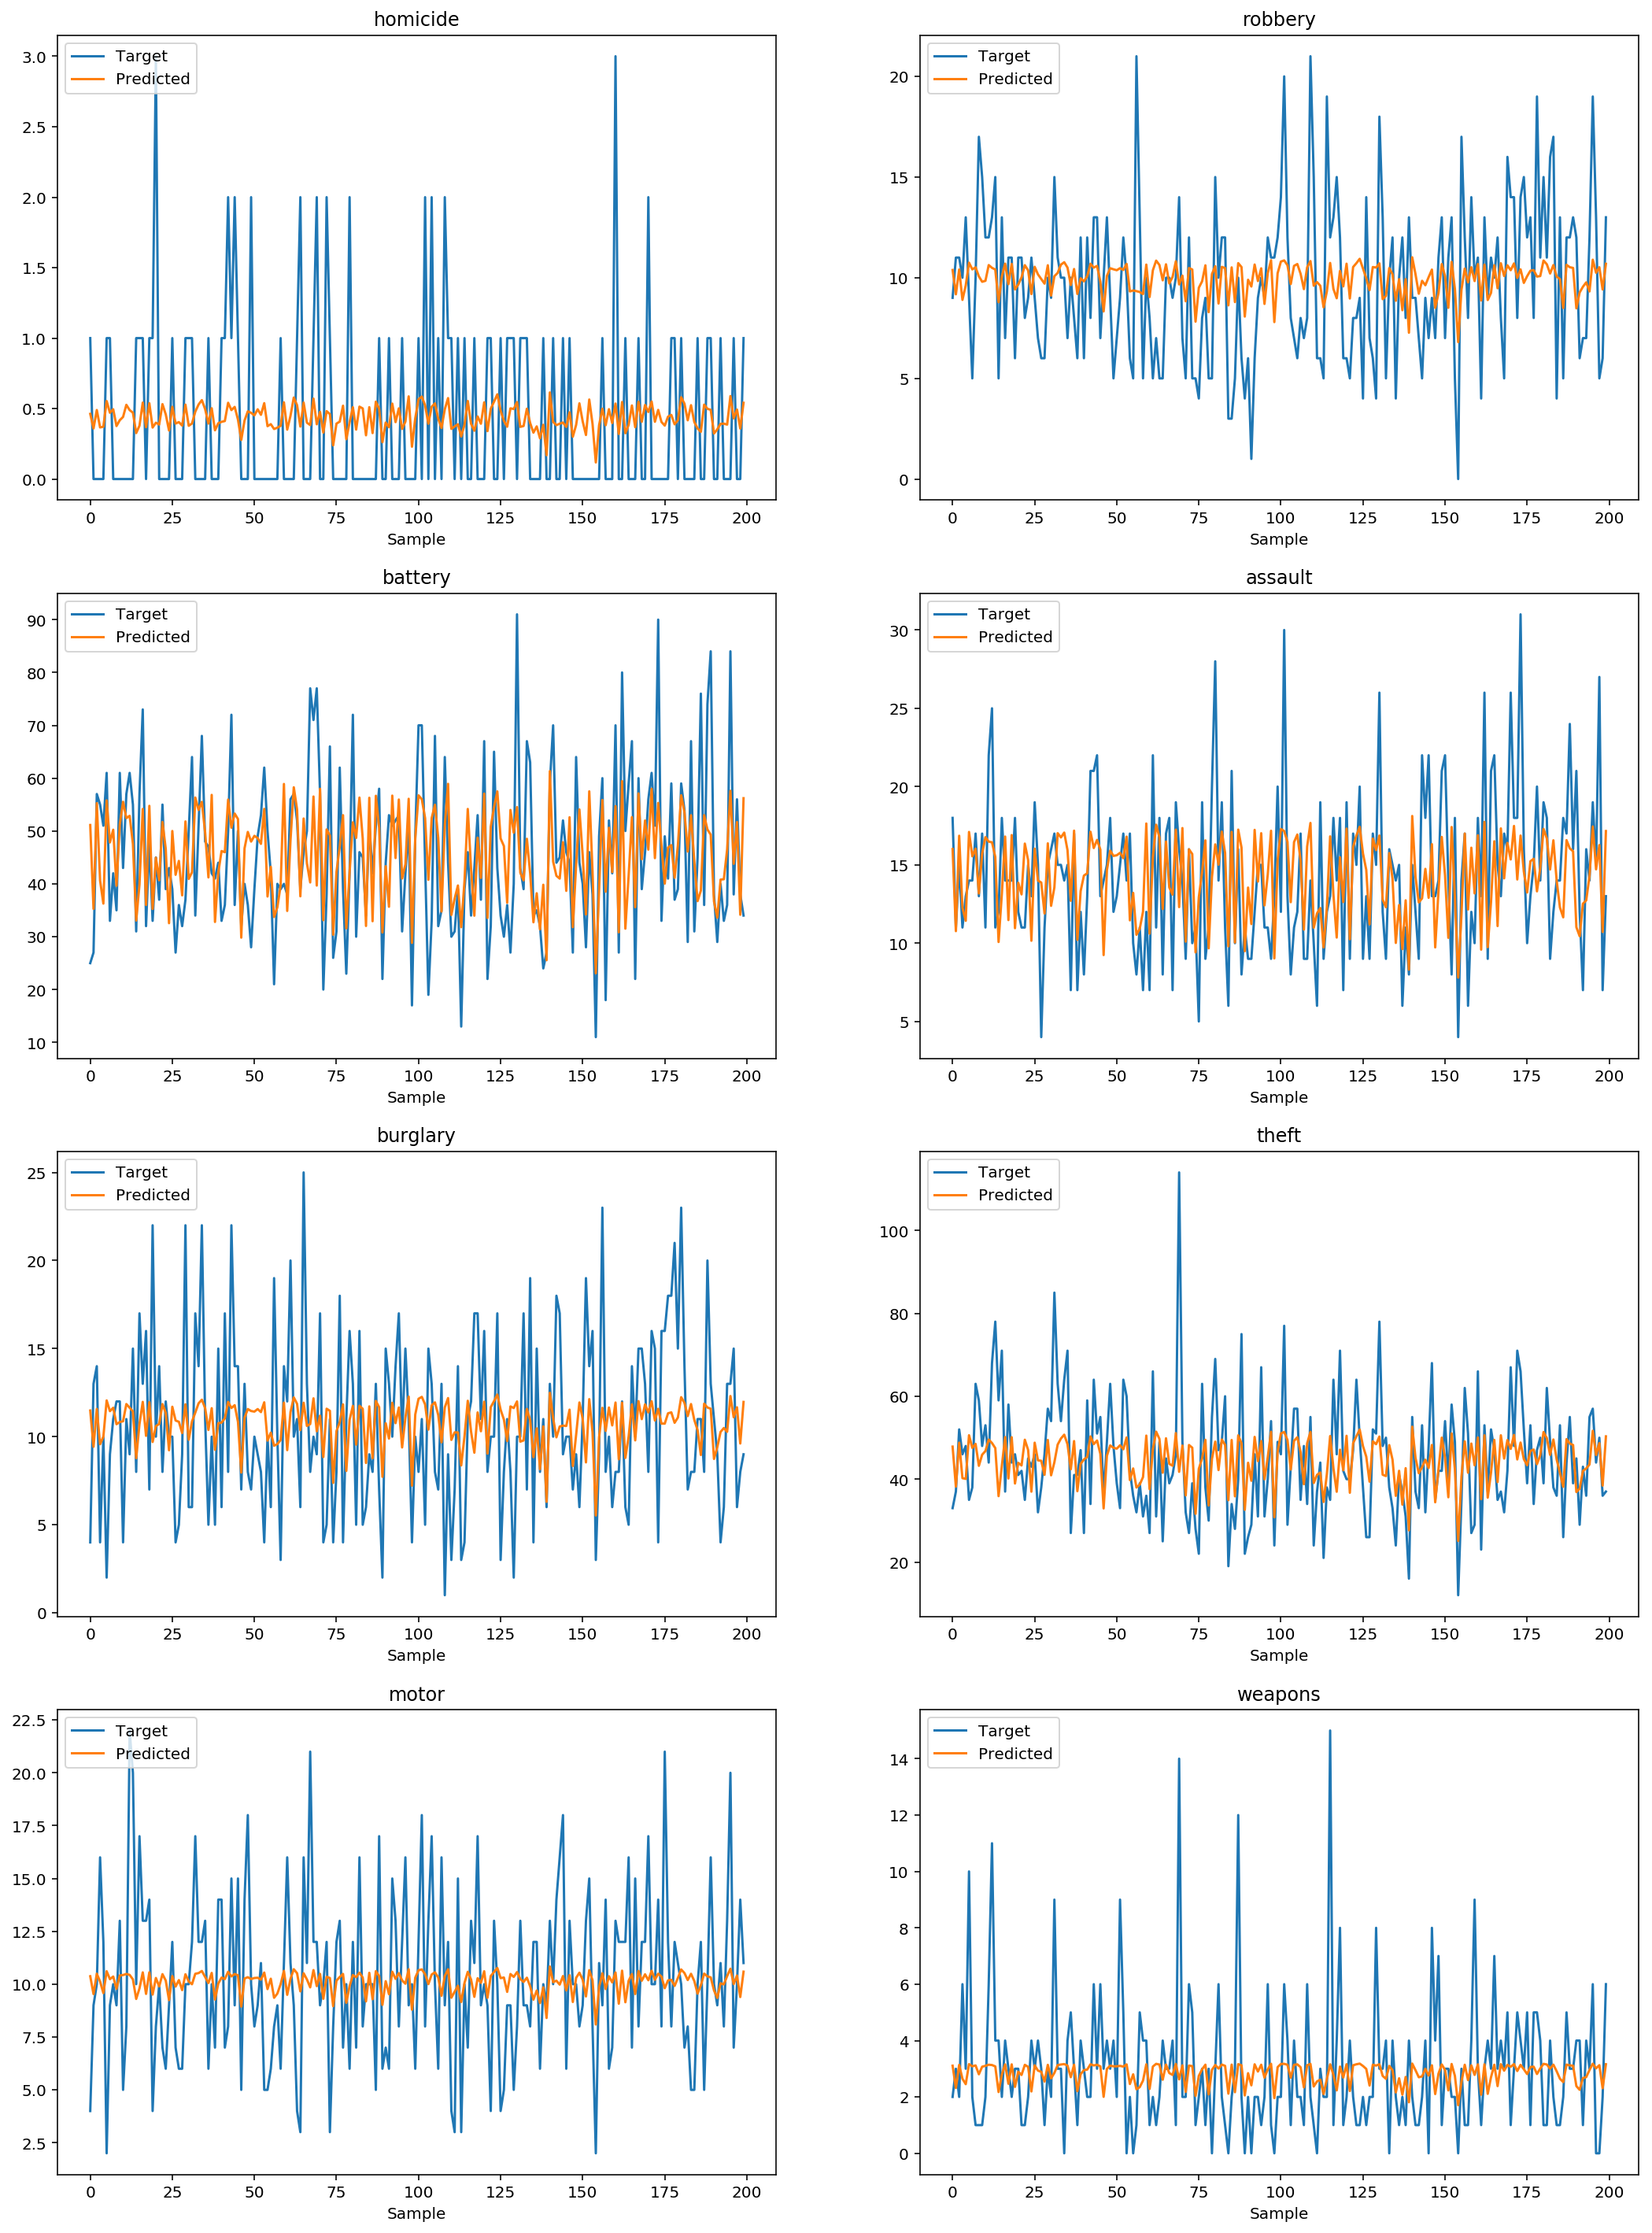

In [28]:
# #############################################################################
# Use the best network
    
itr = 300
train_f = 0.8

network = best[0]
print('Network:', network)
Y, _T, error = get_values(X, T, network, train_f, itr, partition = True)

# #############################################################################
# Results V1.  Showing first 200 samples 

def data_plot(Y, T, error, itr, bound):
    print('ERROR MIN:', np.min(error), 'for', itr, 'iterations')
    print('RMSE:', np.sqrt(np.mean((Y - T)**2)))
    col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']
    
    plt.figure(figsize=(18,25))
    for i in range(T.shape[1]):
        plt.subplot(4,2,i+1)  
        plt.plot(T[:bound,i]), plt.plot(Y[:bound,i])
        plt.title(col[i])
        plt.xlabel('Sample'), plt.ylabel('')
        plt.legend(['Target', 'Predicted'], loc='upper left')
    
    plt.show() 
    
bound = 200
data_plot(Y, _T, error, itr, bound)

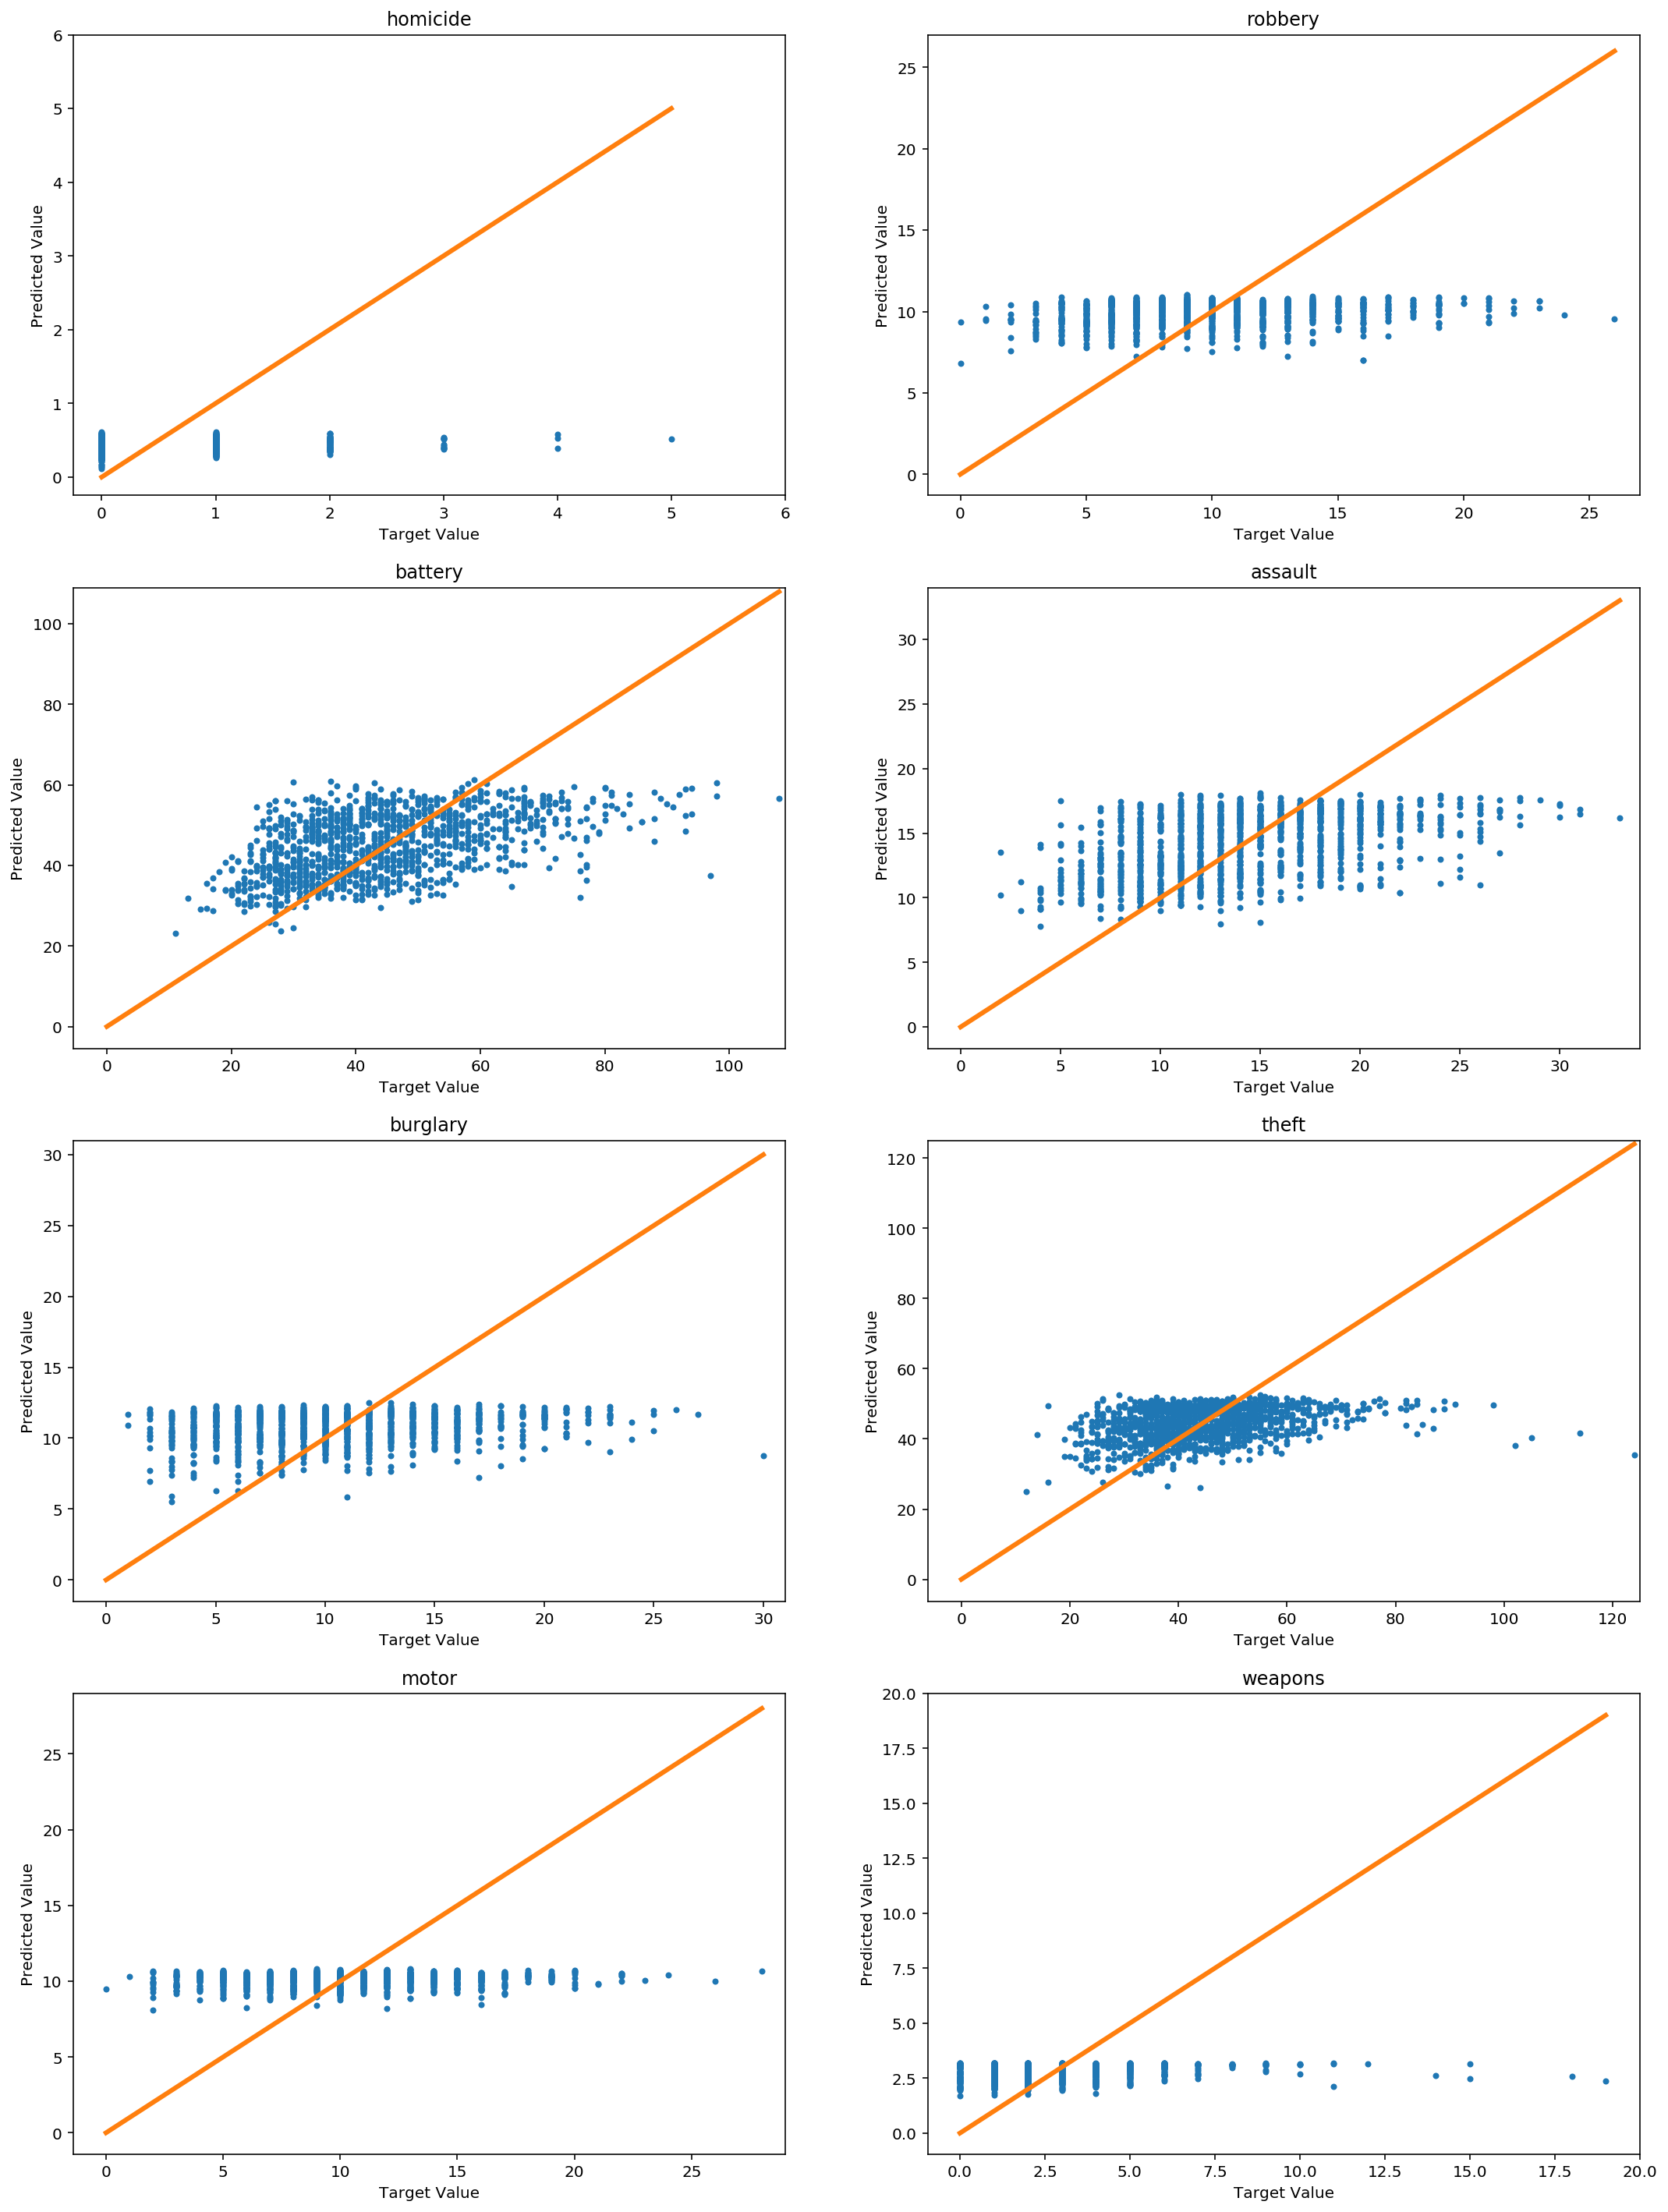

In [29]:
# #############################################################################
# Results V2

col = ['homicide', 'robbery','battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

plt.figure(figsize=(18,25))

for i in range(T.shape[1]):
    m = np.max(_T[:,i]) + 1
    plt.subplot(4,2,i+1)  
    plt.plot(_T[:,i], Y[:,i], '.'), plt.plot(range(m), lw='3')
    axes = plt.gca()
    axes.set_xlim([None,m]), axes.set_ylim([None,m])
    plt.title(col[i])
    plt.xlabel('Target Value'), plt.ylabel('Predicted Value')
    
plt.show()

### Scikit-Learn

Estimators developed for regression:

- LinearRegression
- Ridge
- Lasso
- SVR (SBR, Linear, Ploynomial)

/usr/local/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Linear Regression
train score: 0.0928608791240606
test score: 0.10666113355168351 

Ridge Regression, low alpha
train score: 0.09285424197998593
test score: 0.10669042722417688 

Ridge Regression, high alpha
train score: 0.08511610818128323
test score: 0.09769425918664552 



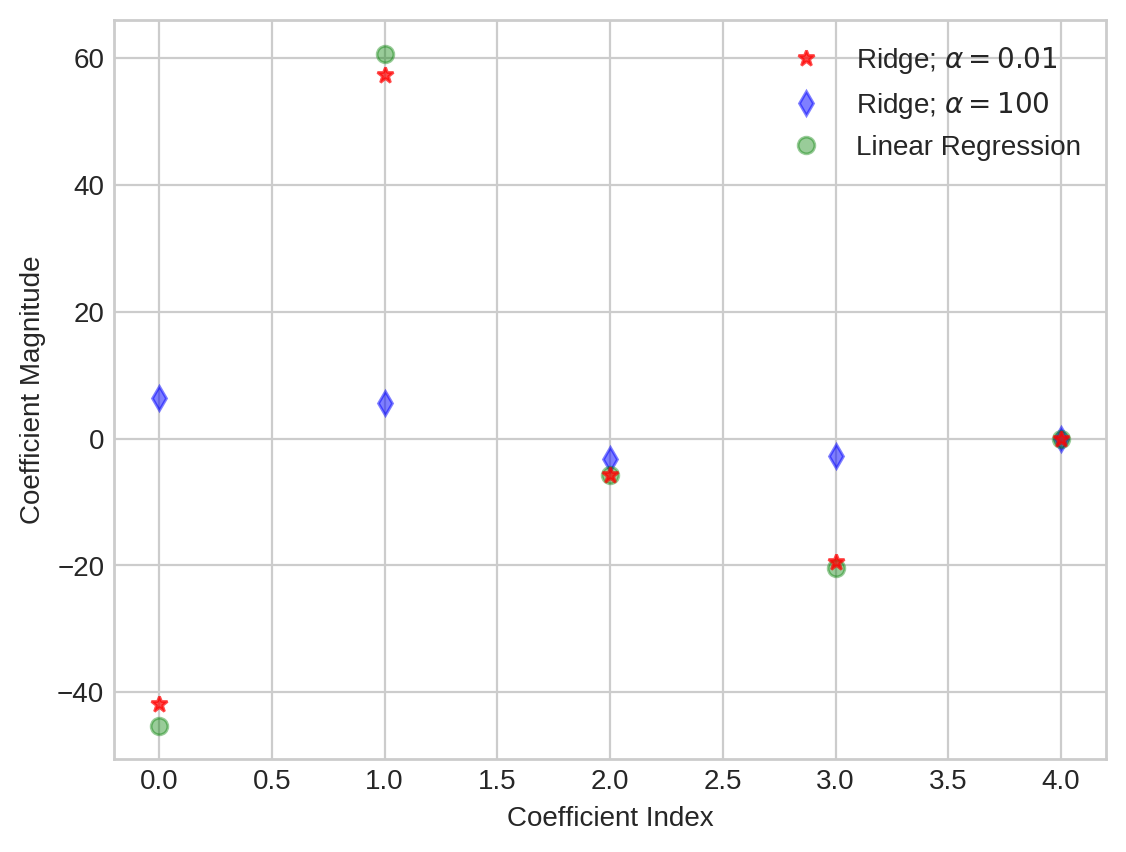

In [21]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# #############################################################################
# Read the data
data = pd.read_csv('../Output/DailyOutput/wc4.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = data['theft']
X = data.drop(['date'] + cols, axis=1)

X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model
lr = LinearRegression()
lr.fit(X_train, T_train)

train_score = lr.score(X_train, T_train)
test_score = lr.score(X_test, T_test)

print('Linear Regression')
print("train score:", train_score)
print("test score:", test_score, '\n')

rr = Ridge(alpha=0.01)
rr.fit(X_train, T_train)

Ridge_train_score = rr.score(X_train, T_train)
Ridge_test_score = rr.score(X_test, T_test)

print('Ridge Regression, low alpha')
print("train score:", Ridge_train_score)
print("test score:", Ridge_test_score, '\n')

rr100 = Ridge(alpha=100)
rr100.fit(X_train, T_train)

Ridge_train_score100 = rr100.score(X_train, T_train)
Ridge_test_score100 = rr100.score(X_test, T_test)

print('Ridge Regression, high alpha')
print("train score:", Ridge_train_score100)
print("test score:", Ridge_test_score100, '\n')

# #############################################################################
# Results
plt.plot(rr.coef_, alpha=0.7, linestyle='none', marker='*',
         color='red', label=r'Ridge; $\alpha = 0.01$', zorder=7)
plt.plot(rr100.coef_, alpha=0.5, linestyle='none', marker='d',
         color='blue', label=r'Ridge; $\alpha = 100$')
plt.plot(lr.coef_, alpha=0.4, linestyle='none', marker='o',
         color='green', label='Linear Regression')

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')

plt.legend(loc=1)
plt.show()

alpha = 0.1
training score: 0.08383764159721885
test score:  0.09641426707672773
number of features used:  2 

alpha = 0.01
training score: 0.09161555052516179
test score:  0.10566774035324888
number of features used: 3 

alpha = 0.0001
training score: 0.09285435489392024
test score:  0.10668948104653452
number of features used: 4 



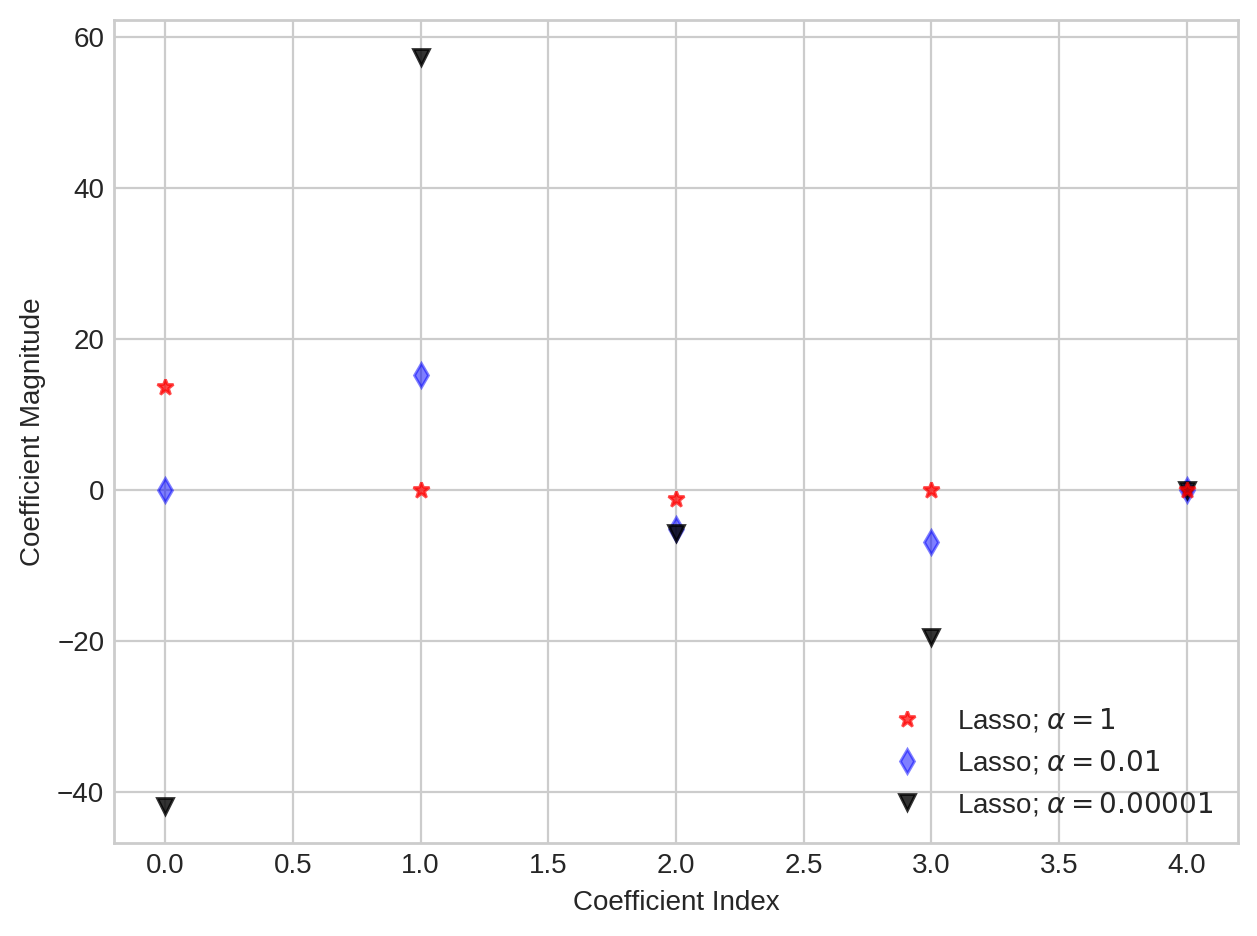

In [22]:
# Difference of lasso and ridge regression is that some of the coefficients can be zero i.e. some of the features are 
# completely neglected
from sklearn.linear_model import Lasso

# #############################################################################
# Read the Data
data = pd.read_csv('../Output/DailyOutput/wc4.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = data['theft']
X = data.drop(['date'] + cols, axis=1)

X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, T_train)
train_score = lasso.score(X_train, T_train)
test_score = lasso.score(X_test, T_test)
coeff_used = np.sum(lasso.coef_!=0)

print('alpha = 0.1')
print("training score:", train_score)
print("test score: ", test_score)
print("number of features used: ", coeff_used, '\n')

lasso001 = Lasso(alpha=0.01, max_iter=10e6)
lasso001.fit(X_train, T_train)
train_score001 = lasso001.score(X_train, T_train)
test_score001 = lasso001.score(X_test, T_test)
coeff_used001 = np.sum(lasso001.coef_!=0)

print('alpha = 0.01')
print("training score:", train_score001)
print("test score: ", test_score001)
print("number of features used:", coeff_used001, '\n')

lasso00001 = Lasso(alpha=0.0001, max_iter=10e6)
lasso00001.fit(X_train, T_train)
train_score00001 = lasso00001.score(X_train, T_train)
test_score00001 = lasso00001.score(X_test, T_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)

print('alpha = 0.0001')
print("training score:", train_score00001)
print("test score: ", test_score00001)
print("number of features used:", coeff_used00001, '\n')

# #############################################################################
# Results
plt.plot(lasso.coef_, alpha=0.7, linestyle='none', marker='*',
         color='red', label=r'Lasso; $\alpha = 1$', zorder=7)
plt.plot(lasso001.coef_, alpha=0.5, linestyle='none', marker='d',
         color='blue', label=r'Lasso; $\alpha = 0.01$')
plt.plot(lasso00001.coef_, alpha=0.8, linestyle='none', marker='v',
         color='black', label=r'Lasso; $\alpha = 0.00001$')

plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Magnitude')
plt.legend(loc=4)

plt.tight_layout()
plt.show()

Kernel RBF
training score: 0.08561572619367153
Kernel Linear
training score: 0.0851777638867588
Kernel Ploy
training score: 0.0855194568060641


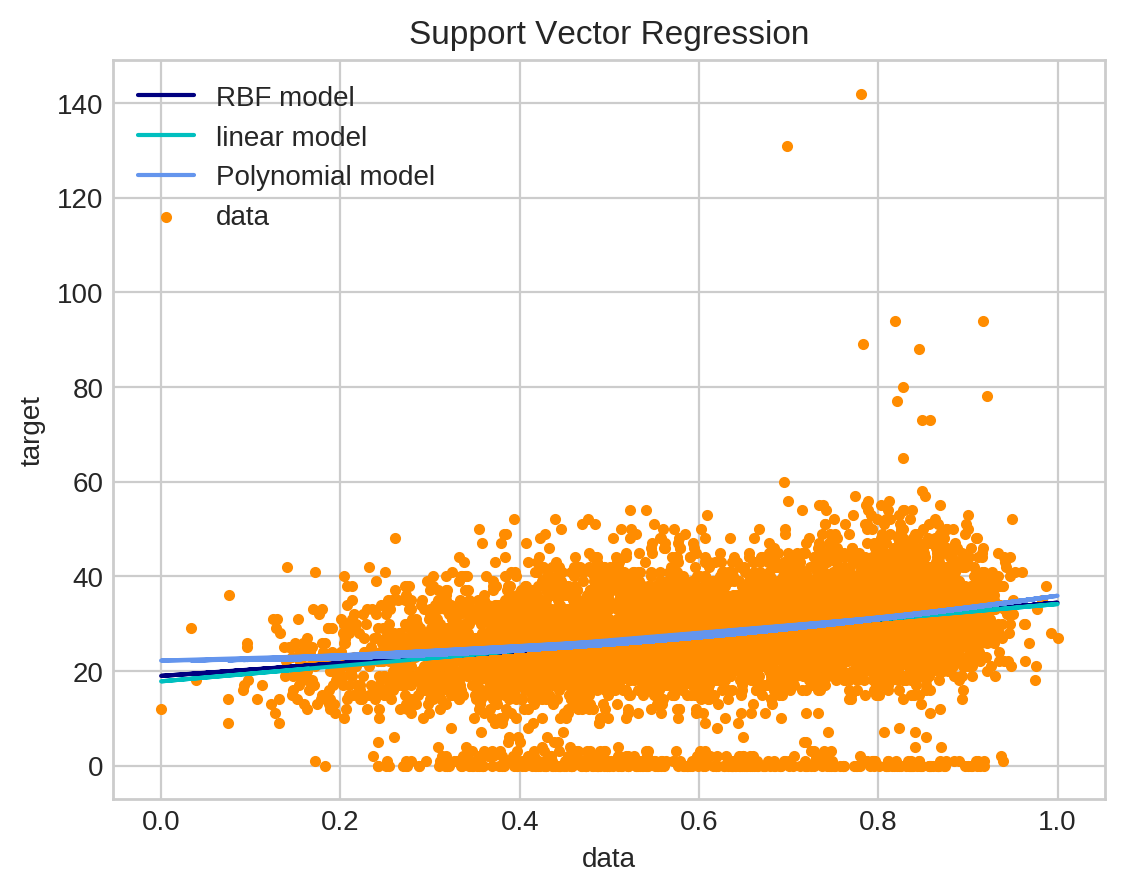

In [23]:
from sklearn.svm import SVR

# #############################################################################
# Read the Data
data = pd.read_csv('../Output/DailyOutput/wc4.csv', sep=',', low_memory=False, 
                   names = ['date', 'dry', 'wet', 'wind',
                            'humidity', 'district', 'homicide', 'robbery',
                            'battery', 'assault', 'burglary', 'theft',
                            'motor', 'weapons'])

cols_to_norm = ['dry', 'wet', 'wind', 'humidity']
data[cols_to_norm] = data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

cols = ['homicide', 'robbery', 'battery', 'assault', 'burglary', 'theft', 'motor', 'weapons']

T = np.array(data['theft'])
X = np.array([[x] for x in data['dry']])

# X_train,X_test,T_train,T_test = train_test_split(X, T, test_size=0.3, random_state=3)

# #############################################################################
# Fit regression model

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
y_rbf = svr_rbf.fit(X, T)
print('Kernel RBF')
print("training score:", y_rbf.score(X, T))
y_rbf = y_rbf.predict(X)

svr_lin = SVR(kernel='linear', C=1e3)
y_lin = svr_lin.fit(X, T)
print('Kernel Linear')
print("training score:", y_lin.score(X, T))
y_lin = y_lin.predict(X)

svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_poly = svr_poly.fit(X, T)
print('Kernel Ploy')
print("training score:", y_poly.score(X, T))
y_poly = y_poly.predict(X)

# #############################################################################
# Results

lw = 1.5
plt.scatter(X, T, marker='.', color='darkorange', label='data')

plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_lin, color='c', lw=lw, label='linear model')
plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')

plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

-- Jason Stock